# Import libraries

In [2]:
import os
import warnings
import itertools
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy import signal
from scipy import stats
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn import preprocessing 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import quaternion

# warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
warnings.simplefilter("ignore")


# Define functions

In [4]:
def time_embed(df, lag):
    lagged_df = df.copy()[lag:].reset_index(drop=True)
    for l in range(1, lag+1):
        lagged_df = pd.merge(lagged_df, df[lag-l:-l].reset_index(drop=True), left_index=True, right_index=True,suffixes=("", "_Lag:{}".format(l)))
    return lagged_df


# Initialize variables

In [6]:
training_data_folder = "training data"
training_user_folders = [f for f in os.listdir(training_data_folder) if os.path.isdir(os.path.join(training_data_folder, f))] # Get list of all user folders for trining
oos_data_folder = "Out-of-sample data"
oos_user_folders = [f for f in os.listdir(oos_data_folder) if os.path.isdir(os.path.join(oos_data_folder, f))] # Get list of all user folders for oos
dfs = [] # Create an empty list to store DataFrames for all user
lag = 9
window_size = 13
K = 0.8 # fraction of data for training (1-K will be used for cross validation)
L = 0.15 # distance of IMU1 from wrist joint
H = 0.05 # distance of IMU2 from wrist joint
wrist_rom = pd.DataFrame(columns=["user","yaw","pitch"]) # empty array for calculating wrist range of motion
wrist_entropy = pd.DataFrame(columns=["user","yaw","pitch"]) # empty array for calculating wrist use of range of motion
wrist_variance = pd.DataFrame(columns=["user","yaw","pitch"]) # empty array for calculating wrist use of range of motion
pitch_bins = np.linspace(-54, 60, 115) # based on Ryu et al. 1991, The Journal of Hand Surgery
yaw_bins = np.linspace(-17, 40, 58) # based on Ryu et al. 1991, The Journal of Hand Surgery


# Feature extraction

In [8]:
# Iterate over each user folder
for user_id in np.arange(len(training_user_folders)):
    user_data_folder = training_data_folder+"/User-"+str(user_id)
    # print( "user "+str(user_id))
    # print(user_data_folder)

    # Load CSV files for each user
    df_falcon = pd.read_csv(os.path.join(user_data_folder, "novint-falcon.csv"))
    df_falcon = df_falcon.rename(columns={'global time': 'Time'}) # rename time column for consistency
    df_imu = pd.read_csv(os.path.join(user_data_folder, "imu.csv"))
    df_angles = pd.read_csv(os.path.join(user_data_folder, "wrist-angles.csv"))
    df_img = pd.read_csv(os.path.join(user_data_folder, "IMG_2 (Instance).csv"))
    
    # Convert time columns to datetime format
    df_falcon['Time'] = pd.to_datetime(df_falcon['Time'].str.strip(), format='%H:%M:%S.%f')
    df_imu['Time'] = pd.to_datetime(df_imu['Time'])
    df_angles['Time'] = pd.to_datetime(df_angles['Time'].str.strip(), format='%I:%M:%S.%f %p')

    # Extract the time from the first row of df_img
    start_time_img = df_img.iloc[0][' time (s)']

    # Find the index of the exact time in df_falcon
    exact_index_falcon = df_falcon[df_falcon[' time (s)'] == start_time_img].index[0]

    # Slice df_falcon from the exact index
    df_falcon = df_falcon.iloc[exact_index_falcon:].reset_index(drop=True)

    # Calculate the time difference for df_angles and df_imu
    time_diff_angles = abs(df_angles['Time'] - df_falcon.iloc[0]['Time'])
    time_diff_imu = abs(df_imu['Time'] - df_falcon.iloc[0]['Time'])

    # Find the index of the minimum time difference
    nearest_index_angles = time_diff_angles.idxmin()
    nearest_index_imu = time_diff_imu.idxmin()

    # Slice df_angles and df_imu from the nearest index
    df_angles = df_angles.iloc[nearest_index_angles:].reset_index()
    df_imu = df_imu.iloc[nearest_index_imu:].reset_index()

    # # Number of raw observsations in each dataset
    # print("falcon observations = "+str(np.shape(df_falcon)[0]))
    # print("imu observations = "+str(np.shape(df_imu)[0]))
    
    # Subset only columns relevant for training
    df_falcon = df_falcon.drop([' time (s)',' rotation_x',' rotation_y'], axis=1)
    df_imu.drop(list(df_imu.filter(regex='2')), axis=1, inplace=True) # remove anything with IMU2 that is placed on the back of the hand

    # Downsample the falcon data
    df_falcon_downsampled = pd.DataFrame(columns=df_falcon.keys())
    for ts in np.arange(len(df_angles)):
        min_index = abs(df_angles.iloc[ts]['Time'] - df_falcon['Time']).idxmin()
        df_falcon_downsampled.loc[len(df_falcon_downsampled.index)] = df_falcon.iloc[min_index-2:min_index+3][[' falcon_x',' falcon_y',' falcon_z']].mean()
    df_falcon = pd.concat([df_angles['Time'],df_falcon_downsampled.drop('Time', axis=1).reset_index(drop=True)], axis=1)

    # remove drift from IMU1 yaw
    m,b = np.polyfit(np.arange(np.shape(df_imu)[0]), df_imu["Yaw1"], 1)
    df_imu["Yaw1"] = df_imu["Yaw1"]-(m*np.arange(np.shape(df_imu)[0])+b)    

    # apply a median filter on all raw data
    df_angles["Roll"] = signal.medfilt(df_angles["Roll"],kernel_size=window_size)
    df_angles["Pitch"] = signal.medfilt(df_angles["Pitch"],kernel_size=window_size)
    df_angles["Yaw"] = signal.medfilt(df_angles["Yaw"],kernel_size=window_size)
    df_falcon[" falcon_x"] = signal.medfilt(df_falcon[" falcon_x"],kernel_size=window_size)
    df_falcon[" falcon_y"] = signal.medfilt(df_falcon[" falcon_y"],kernel_size=window_size)
    df_falcon[" falcon_z"] = signal.medfilt(df_falcon[" falcon_z"],kernel_size=window_size)
    df_imu["Yaw1"] = signal.medfilt(df_imu["Yaw1"],kernel_size=window_size)
    df_imu["Pitch1"] = signal.medfilt(df_imu["Pitch1"],kernel_size=window_size)
    df_imu["Roll1"] = signal.medfilt(df_imu["Roll1"],kernel_size=window_size)
    df_imu["AccX1"] = signal.medfilt(df_imu["AccX1"],kernel_size=window_size)
    df_imu["AccY1"] = signal.medfilt(df_imu["AccY1"],kernel_size=window_size)
    df_imu["AccZ1"] = signal.medfilt(df_imu["AccZ1"],kernel_size=window_size)
    df_imu["RotX1"] = signal.medfilt(df_imu["RotX1"],kernel_size=window_size)
    df_imu["RotY1"] = signal.medfilt(df_imu["RotY1"],kernel_size=window_size)
    df_imu["RotZ1"] = signal.medfilt(df_imu["RotZ1"],kernel_size=window_size)

    # add time derivatives in falcon data
    df_falcon["falcon_x_dot"] = df_falcon[" falcon_x"]
    df_falcon["falcon_y_dot"] = df_falcon[" falcon_y"]
    df_falcon["falcon_z_dot"] = df_falcon[" falcon_z"]
    for ts in np.arange(((window_size-1)/2),len(df_falcon)-((window_size-1)/2)):
        df_falcon.loc[ts, 'falcon_x_dot'] = (df_falcon[" falcon_x"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_x"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_falcon.loc[ts, 'falcon_y_dot'] = (df_falcon[" falcon_y"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_y"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_falcon.loc[ts, 'falcon_z_dot'] = (df_falcon[" falcon_z"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_z"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()

    # add time integrals in IMU data
    df_imu["VelX1"] = df_imu["AccX1"]
    df_imu["VelY1"] = df_imu["AccY1"]
    df_imu["VelZ1"] = df_imu["AccZ1"]    
    for ts in np.arange(((window_size-1)/2),len(df_imu)-((window_size-1)/2)):
        df_imu.loc[ts,'VelX1'] = (df_imu["AccX1"].loc[ts+((window_size-1)/2)]-df_imu["AccX1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'VelY1'] = (df_imu["AccY1"].loc[ts+((window_size-1)/2)]-df_imu["AccY1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'VelZ1'] = (df_imu["AccZ1"].loc[ts+((window_size-1)/2)]-df_imu["AccZ1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
    
    # add time integrals in IMU data
    df_imu["PosX1"] = df_imu["AccX1"]
    df_imu["PosY1"] = df_imu["AccY1"]
    df_imu["PosZ1"] = df_imu["AccZ1"]    
    for ts in np.arange(((window_size-1)/2),len(df_imu)-((window_size-1)/2)):
        df_imu.loc[ts,'PosX1'] = (df_imu["VelX1"].loc[ts+((window_size-1)/2)]-df_imu["VelX1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'PosY1'] = (df_imu["VelY1"].loc[ts+((window_size-1)/2)]-df_imu["VelY1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'PosZ1'] = (df_imu["VelZ1"].loc[ts+((window_size-1)/2)]-df_imu["VelZ1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()

    # add features from the kinematic model
    df_imu["sin(Pitch1)"] = np.sin(df_imu["Pitch1"].astype(float).apply(math.radians))
    df_imu["sin(Yaw1)"] = np.sin(df_imu["Yaw1"].astype(float).apply(math.radians))
    df_imu["sin(Roll1)"] = np.sin(df_imu["Roll1"].astype(float).apply(math.radians))
    df_imu["cos(Pitch1)"] = np.cos(df_imu["Pitch1"].astype(float).apply(math.radians))
    df_imu["cos(Yaw1)"] = np.cos(df_imu["Yaw1"].astype(float).apply(math.radians))
    df_imu["cos(Roll1)"] = np.cos(df_imu["Roll1"].astype(float).apply(math.radians))
    df_imu["RotX1*sin(Pitch1)"] = df_imu["RotX1"]*df_imu["sin(Pitch1)"]
    df_imu["RotY1*sin(Pitch1)"] = df_imu["RotY1"]*df_imu["sin(Pitch1)"]
    df_imu["RotZ1*sin(Pitch1)"] = df_imu["RotZ1"]*df_imu["sin(Pitch1)"]
    df_imu["RotX1*sin(Yaw1)"] = df_imu["RotX1"]*df_imu["sin(Yaw1)"]
    df_imu["RotY1*sin(Yaw1)"] = df_imu["RotY1"]*df_imu["sin(Yaw1)"]
    df_imu["RotZ1*sin(Yaw1)"] = df_imu["RotZ1"]*df_imu["sin(Yaw1)"]
    df_imu["RotX1*sin(Roll1)"] = df_imu["RotX1"]*df_imu["sin(Roll1)"]
    df_imu["RotY1*sin(Roll1)"] = df_imu["RotY1"]*df_imu["sin(Roll1)"]
    df_imu["RotZ1*sin(Roll1)"] = df_imu["RotZ1"]*df_imu["sin(Roll1)"]
    df_imu["RotX1*cos(Pitch1)"] = df_imu["RotX1"]*df_imu["cos(Pitch1)"]
    df_imu["RotY1*cos(Pitch1)"] = df_imu["RotY1"]*df_imu["cos(Pitch1)"]
    df_imu["RotZ1*cos(Pitch1)"] = df_imu["RotZ1"]*df_imu["cos(Pitch1)"]
    df_imu["RotX1*cos(Yaw1)"] = df_imu["RotX1"]*df_imu["cos(Yaw1)"]
    df_imu["RotY1*cos(Yaw1)"] = df_imu["RotY1"]*df_imu["cos(Yaw1)"]
    df_imu["RotZ1*cos(Yaw1)"] = df_imu["RotZ1"]*df_imu["cos(Yaw1)"]
    df_imu["RotX1*cos(Roll1)"] = df_imu["RotX1"]*df_imu["cos(Roll1)"]
    df_imu["RotY1*cos(Roll1)"] = df_imu["RotY1"]*df_imu["cos(Roll1)"]
    df_imu["RotZ1*cos(Roll1)"] = df_imu["RotZ1"]*df_imu["cos(Roll1)"]
    df_imu["arctan"] = np.arctan(np.nan_to_num(((-df_imu["VelX1"]+df_falcon["falcon_x_dot"]-L*df_imu["RotY1"]*df_imu["sin(Pitch1)"])/(df_imu["VelY1"]-df_falcon["falcon_y_dot"]+L*df_imu["RotY1"]*df_imu["cos(Pitch1)"])).apply(math.radians)))+df_imu["Pitch1"]


    # apply a median filter on computed values
    df_falcon["falcon_x_dot"] = signal.medfilt(df_falcon["falcon_x_dot"],kernel_size=window_size)
    df_falcon["falcon_y_dot"] = signal.medfilt(df_falcon["falcon_y_dot"],kernel_size=window_size)
    df_falcon["falcon_z_dot"] = signal.medfilt(df_falcon["falcon_z_dot"],kernel_size=window_size)
    df_imu["VelX1"] = signal.medfilt(df_imu["VelX1"],kernel_size=window_size)
    df_imu["VelY1"] = signal.medfilt(df_imu["VelY1"],kernel_size=window_size)
    df_imu["VelZ1"] = signal.medfilt(df_imu["VelZ1"],kernel_size=window_size)
    df_imu["PosX1"] = signal.medfilt(df_imu["PosX1"],kernel_size=window_size)
    df_imu["PosY1"] = signal.medfilt(df_imu["PosY1"],kernel_size=window_size)
    df_imu["PosZ1"] = signal.medfilt(df_imu["PosZ1"],kernel_size=window_size)
    df_imu["sin(Pitch1)"] = signal.medfilt(df_imu["sin(Pitch1)"],kernel_size=window_size)
    df_imu["sin(Yaw1)"] = signal.medfilt(df_imu["sin(Yaw1)"],kernel_size=window_size)
    df_imu["sin(Roll1)"] = signal.medfilt(df_imu["sin(Roll1)"],kernel_size=window_size)
    df_imu["cos(Pitch1)"] = signal.medfilt(df_imu["cos(Pitch1)"],kernel_size=window_size)
    df_imu["cos(Yaw1)"] = signal.medfilt(df_imu["cos(Yaw1)"],kernel_size=window_size)
    df_imu["cos(Roll1)"] = signal.medfilt(df_imu["cos(Roll1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Pitch1)"] = signal.medfilt(df_imu["RotX1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Pitch1)"] = signal.medfilt(df_imu["RotY1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Pitch1)"] = signal.medfilt(df_imu["RotZ1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Yaw1)"] = signal.medfilt(df_imu["RotX1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Yaw1)"] = signal.medfilt(df_imu["RotY1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Yaw1)"] = signal.medfilt(df_imu["RotZ1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Roll1)"] = signal.medfilt(df_imu["RotX1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Roll1)"] = signal.medfilt(df_imu["RotY1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Roll1)"] = signal.medfilt(df_imu["RotZ1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Pitch1)"] = signal.medfilt(df_imu["RotX1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Pitch1)"] = signal.medfilt(df_imu["RotY1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Pitch1)"] = signal.medfilt(df_imu["RotZ1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Yaw1)"] = signal.medfilt(df_imu["RotX1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Yaw1)"] = signal.medfilt(df_imu["RotY1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Yaw1)"] = signal.medfilt(df_imu["RotZ1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Roll1)"] = signal.medfilt(df_imu["RotX1*cos(Roll1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Roll1)"] = signal.medfilt(df_imu["RotY1*cos(Roll1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Roll1)"] = signal.medfilt(df_imu["RotZ1*cos(Roll1)"],kernel_size=window_size)
    df_imu["arctan"] = signal.medfilt(df_imu["arctan"],kernel_size=window_size)
    
    # change the time colmns to index to merge time series into a single dataframe
    df_angles = df_angles.set_index(['Time'])
    df_falcon = df_falcon.set_index(['Time'])
    df_imu = df_imu.set_index(['Time'])
    
    # # print the lenth of the interaction in time
    # print("falcon observations = "+str(np.shape(df_falcon)[0]))
    # print("duration = "+str(df_imu.reset_index()["Time"][np.shape(df_imu)[0]-1]-df_imu.reset_index()["Time"][0]))

    # Merge time series into a single dataframe
    df_data = pd.merge(df_angles, df_falcon, left_index=True, right_index=True)
    df_data = pd.merge(df_data, df_imu, left_index=True, right_index=True)

    # Revert index back to numerics
    df_data = df_data.reset_index(drop=True)
    
    # Lag the merged data
    df_data = time_embed(df_data, lag)

    # remove rows with NaN values
    df_data = df_data.dropna()

    # Add user ID column
    df_data['User'] = user_id

    # compute user's range of motion and entropy along yaw, pitch, and roll
    wrist_rom.loc[len(wrist_rom)] = [user_id,
                                 max(df_data.Yaw)-min(df_data.Yaw),
                                 max(df_data.Pitch)-min(df_data.Pitch)]
    
    wrist_variance.loc[len(wrist_variance)] = [user_id,
                                 np.var(df_data.Yaw),
                                 np.var(df_data.Pitch)]
    
    wrist_entropy.loc[len(wrist_entropy)] = [user_id,
                                 -np.nansum(np.histogram(df_data["Yaw"],yaw_bins)[0]/np.sum(np.histogram(df_data["Yaw"],yaw_bins)[0])*np.log10(np.histogram(df_data["Yaw"],yaw_bins)[0]/np.sum(np.histogram(df_data["Yaw"],yaw_bins)[0]))),
                                 -np.nansum(np.histogram(df_data["Pitch"],pitch_bins)[0]/np.sum(np.histogram(df_data["Pitch"],pitch_bins)[0])*np.log10(np.histogram(df_data["Pitch"],pitch_bins)[0]/np.sum(np.histogram(df_data["Pitch"],pitch_bins)[0])))]


    # Append to the list of DataFrames
    dfs.append(df_data)

# Convert the dataframes into a pandas dataframe
features = pd.concat(dfs)

# remove irrelevant columns
features.drop(list(features.filter(regex='index')), axis=1, inplace=True)
features.drop(list(features.filter(regex='Roll_Lag:')), axis=1, inplace=True)
features.drop(list(features.filter(regex='Pitch_Lag:')), axis=1, inplace=True)
features.drop(list(features.filter(regex='Yaw_Lag:')), axis=1, inplace=True)
features.drop(list(features.filter(regex='Unnamed')), axis=1, inplace=True)

# # Save merged data to a new CSV file
# features.to_csv('features.csv')


# Test for autoregression and find optimal lag

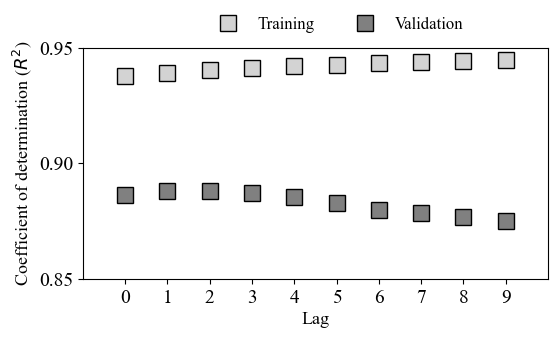

Optimal lag: 2
Optimal R2: 0.8879773913619203
Optimal R2 in training: 0.9391486332045013
Maximum $R^2$ for training: 0.9448419029315748
Maximum $R^2$ for cross-validation: 0.8879773913619203
Average difference between training and validation: 0.05914011929131813


In [10]:
# define structures for cross-validations
num_vars = np.shape(df_falcon.drop(list(df_falcon.filter(regex='index')), axis=1))[1] + np.shape(df_imu.drop(list(df_imu.filter(regex='index')), axis=1))[1]-1
gof_cross_validation = pd.DataFrame(columns=["lag","r-sq","mse"]) # empty array for goodness-of-fit measurements
gof_training = pd.DataFrame(columns=["lag","r-sq","mse"]) # empty array for goodness-of-fit measurements

# define the input and output of the machine learning algorithm
training_features = features[features['User'].isin([1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17])] # remove user 0 (author of the paper)
Y = training_features[["Pitch","Yaw","Roll"]]
X = training_features.drop(["Pitch","Yaw","Roll"], axis=1)

# iterate throught lags
for l in np.arange(lag+1):
    # print("lag "+str(l))
    
    # get only columns up to lag l
    x = X.iloc[:,list(range(0, num_vars*(l+1)))]

    # define training and validation data sets
    X_train = pd.DataFrame(columns=x.keys())
    X_test = pd.DataFrame(columns=x.keys())
    Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
    Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
    for id in np.unique(features["User"]):
        X_train = pd.concat([X_train, x[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
        X_test = pd.concat([X_test, x[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])
        Y_train = pd.concat([Y_train, Y[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
        Y_test = pd.concat([Y_test, Y[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])
        
    # Train linear regression model for pitch
    model = LinearRegression()
    model.fit(X_train,Y_train[["Pitch"]])
    predictions = model.predict(X_test) 
    
    # Compute R-squared and MSE for cross validation
    gof_cross_validation.loc[len(gof_cross_validation)] = [l, r2_score(Y_test[["Pitch"]], predictions), mean_squared_error(Y_test[["Pitch"]], predictions)]
    
    # Compute R-squared and MSE for training
    training_predictions = model.predict(X_train)
    gof_training.loc[len(gof_cross_validation)] = [l, r2_score(Y_train[["Pitch"]], training_predictions), mean_squared_error(Y_train[["Pitch"]], training_predictions)]

# identify the optimal lag
plt.figure(figsize=(6,3))
x = np.arange(lag+1)
y1 = gof_training['r-sq']
y2 = gof_cross_validation['r-sq']
plt.plot(x, y1, 'bs',markersize=12,markerfacecolor='lightgrey',markeredgecolor='black')
plt.plot(x, y2, 'bs',markersize=12,markerfacecolor='grey',markeredgecolor='black')
plt.ylabel(r'Coefficient of determination ($R^2$)', fontsize=13, fontname='Times New Roman')
plt.xlabel('Lag', fontsize=13, fontname='Times New Roman')
plt.xticks(np.arange(0,10), fontsize=14, fontname='Times New Roman')
plt.yticks([0.85, 0.9, 0.95], fontsize=14, fontname='Times New Roman')
plt.xlim([-1, lag+1])
plt.ylim([0.85, 0.95])
plt.legend(['Training','Validation'],bbox_to_anchor=(0.85, 1.2), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
plt.savefig('Figure5a.pdf')
plt.show()

# store values for optimal model
opt_lag = int(gof_cross_validation[gof_cross_validation["r-sq"]==max(gof_cross_validation["r-sq"])]["lag"])
opt_r2_tr = gof_training["r-sq"][opt_lag]
opt_r2_val = gof_cross_validation["r-sq"][opt_lag]
opt_mse_tr = gof_training["mse"][opt_lag]
opt_mse_val = gof_cross_validation["mse"][opt_lag]

print("Optimal lag: "+str(opt_lag))
print("Optimal R2: "+str(opt_r2_val))
print("Optimal R2 in training: "+str(opt_r2_tr))
print(r'Maximum $R^2$ for training: '+str(max(gof_training["r-sq"])))
print(r'Maximum $R^2$ for cross-validation: '+str(max(gof_cross_validation["r-sq"])))
print("Average difference between training and validation: "+str(np.mean(gof_training["r-sq"].reset_index(drop=True)-gof_cross_validation["r-sq"])))


# Apply a linear regression model with optimal lag

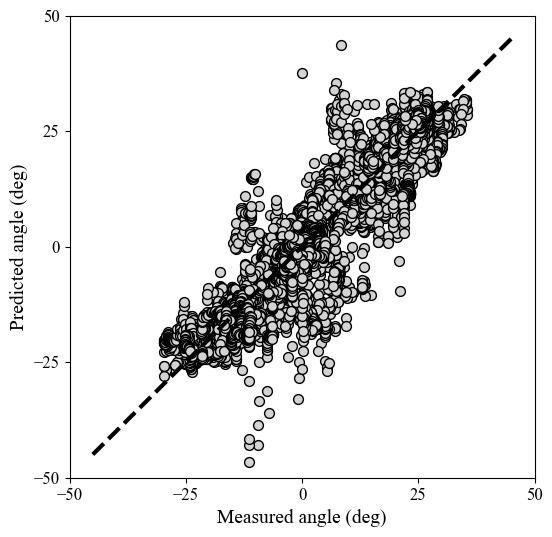

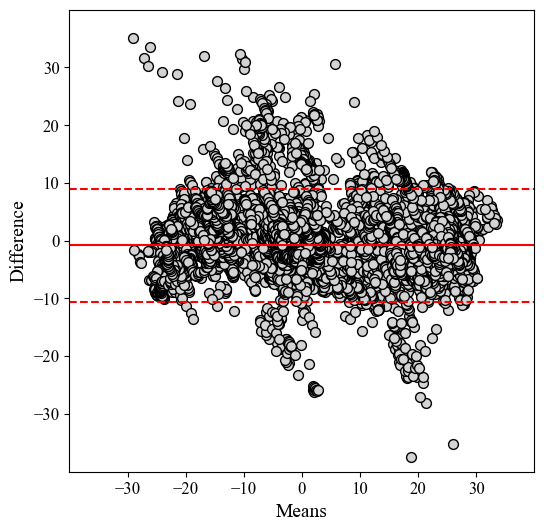

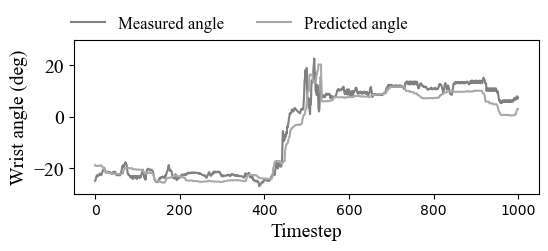

Testing R-squared: 0.8879773913619203
Testing MSE: 25.684361352948226
Range of measured angles:  -29.7374357729918  to  35.4243792649286
Mean of measured angles:  5.462871466890446 +- Pitch    15.141941
dtype: float64
Range of predicted angles:  -46.57159910851419  to  43.65549155225892
Mean of predicted angles:  6.263029113395205 +- 16.04555791419672
Training R-squared: 0.940220539285995
Training MSE: 17.60036773878842
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                 1.657e+05
Date:                Sun, 28 Sep 2025   Prob (F-statistic):               0.00
Time:                        16:43:23   Log-Likelihood:                -54056.
No. Observations:               17846   AIC:                         1.081e+05
Df Residuals:          

In [12]:
# define the input and output of the machine learning algorithm with no autoregressive terms
Y = training_features[["Pitch","Yaw","Roll"]]
X = training_features.drop(["Pitch","Yaw","Roll"], axis=1)

# get only columns up to optimal lag
x = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))]

# define training and validation data sets
X_train = pd.DataFrame(columns=x.keys())
X_test = pd.DataFrame(columns=x.keys())
Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
for id in np.unique(training_features["User"]):
    X_train = pd.concat([X_train, x[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
    X_test = pd.concat([X_test, x[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])
    Y_train = pd.concat([Y_train, Y[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
    Y_test = pd.concat([Y_test, Y[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])

# Train linear regression model
opt_model = LinearRegression()
opt_model.fit(X_train, Y_train[["Pitch"]])
predictions = opt_model.predict(X_test)

# Scatter plot predictions vs. actual angles
plt.figure(figsize=(6,6))
plt.scatter(Y_test[["Pitch"]], predictions, edgecolors='k',c='lightgrey',s=50)
plt.plot([-45, 45], [-45, 45], color='black', linestyle='dashed', lw=3)
plt.ylabel('Predicted angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xlabel('Measured angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xticks([-50, -25, 0, 25, 50], fontsize=12, fontname='Times New Roman')
plt.yticks([-50, -25, 0, 25, 50], fontsize=12, fontname='Times New Roman')
plt.ylim([-50, 50])
plt.xlim([-50, 50])
# plt.savefig('Figure5b.pdf')
plt.show()

# create a Bland-Altman plot
data1 = np.asarray(Y_test[["Pitch"]])
data2 = np.asarray(predictions)
mean = np.mean([data1, data2], axis=0)
diff = data1 - data2
md = np.mean(diff)
sd = np.std(diff, axis=0)

plt.figure(figsize=(6,6))
plt.scatter(mean, diff, edgecolors='k',c='lightgrey',s=50)
plt.axhline(md,color='red', linestyle='-')
plt.axhline(md+1.96*sd, color='red', linestyle='--')
plt.axhline(md-1.96*sd, color='red', linestyle='--')
plt.ylabel('Difference', fontsize=14, fontname='Times New Roman')
plt.xlabel('Means', fontsize=14, fontname='Times New Roman')
plt.xticks([-30, -20, -10, 0, 10, 20, 30], fontsize=12, fontname='Times New Roman')
plt.yticks([-30, -20, -10, 0, 10, 20, 30], fontsize=12, fontname='Times New Roman')
plt.ylim([-40, 40])
plt.xlim([-40, 40])
# plt.savefig('Bland-Altman.pdf')
plt.show()

# Plot ground truth wrist angle versus the predicted wrist angle
plt.figure(figsize=(6,2))
plt.plot(np.arange(1000), predictions[1500:2500], markersize=12,color='grey',markeredgecolor='black')
plt.plot(np.arange(1000), Y_test["Pitch"][1500:2500], markersize=12,color='darkgrey',markeredgecolor='black')
plt.ylabel(r'Wrist angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xlabel('Timestep', fontsize=14, fontname='Times New Roman')
# plt.xticks([start_ind, end_ind], fontsize=12, fontname='Times New Roman')
plt.yticks([-20,0,20], fontsize=14, fontname='Times New Roman')
plt.ylim([-30, 30])
plt.legend([r'Measured angle',r'Predicted angle'],bbox_to_anchor=(0.75, 1.25), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure5c.pdf')
plt.show()

# Goodness-of-fit in cross-validation
r_squared = r2_score(Y_test[["Pitch"]], predictions)
print("Testing R-squared:", r_squared)
mse = mean_squared_error(Y_test[["Pitch"]], predictions)
print("Testing MSE:", mse)
print("Range of measured angles: ", np.min(Y_test[["Pitch"]]), " to ", np.max(Y_test[["Pitch"]]))
print("Mean of measured angles: ", np.mean(Y_test[["Pitch"]]), "+-", np.std(Y_test[["Pitch"]]))
print("Range of predicted angles: ", np.min(predictions), " to ", np.max(predictions))
print("Mean of predicted angles: ", np.mean(predictions), "+-", np.std(predictions))

# Goodness-of-fit in training
training_predictions = opt_model.predict(X_train)
r_squared = r2_score(Y_train[["Pitch"]], training_predictions) # Compute R-squared
print("Training R-squared:", r_squared)
mse = mean_squared_error(Y_train[["Pitch"]], training_predictions) # Compute MSE
print("Training MSE:", mse)

# Apply OLS regression to compute confidence intervals and p-values
ols_model = sm.OLS(predictions, sm.add_constant(Y_test[["Pitch"]]))
ols_results = ols_model.fit()
print(ols_results.summary())


# Quantify feature importance

Most important features:
0     sin(Yaw1)_Lag:2
1     cos(Yaw1)_Lag:2
2           cos(Yaw1)
3         sin(Pitch1)
4    sin(Roll1)_Lag:2
Name: Feature, dtype: object


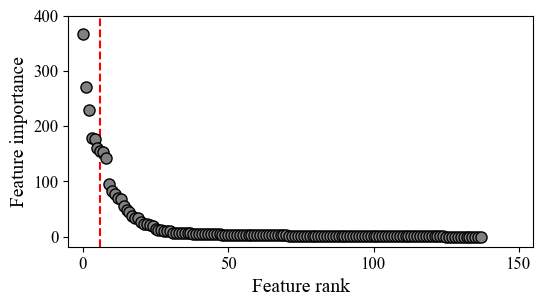

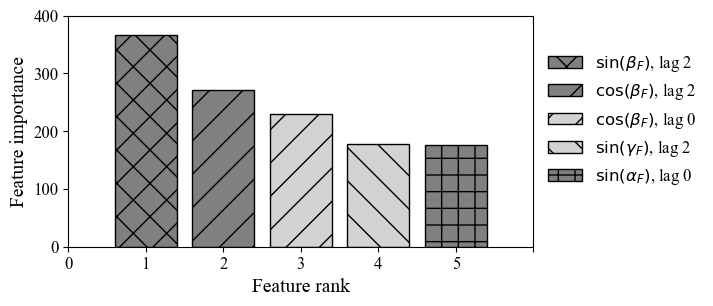

In [14]:
# Get feature names
feature_names = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))].columns

# Get coefficients
coefficients = opt_model.coef_[0,:]

# Create a dataframe for feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})

# Sort by absolute importance
feature_importance['Abs Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values('Abs Importance', ascending=False).reset_index()

# Identify the most important features
contrib_to_importance = np.cumsum(feature_importance["Abs Importance"]/np.sum(feature_importance["Abs Importance"]))
fraction_contribution = 0.5
num_features = np.where(np.abs(contrib_to_importance-fraction_contribution)==np.min(np.abs(contrib_to_importance-fraction_contribution)))[0][0]
print("Most important features:")
print(feature_importance[0:num_features]["Feature"])

# Display feature importance
x = np.arange(np.shape(feature_importance['Abs Importance'])[0])
y = feature_importance['Abs Importance']
fig = plt.figure(figsize=(6,3))
plt.axvline(x=num_features+1,linestyle="dashed", color="red")
plt.plot(x, y, 'o',markersize=8,markerfacecolor='grey',markeredgecolor='black')
plt.ylabel('Feature importance', fontsize=14, fontname='Times New Roman')
plt.xlabel('Feature rank', fontsize=14, fontname='Times New Roman')
plt.xticks([0, 50, 100, 150], fontsize=12, fontname='Times New Roman')
plt.yticks([0, 100, 200, 300, 400], fontsize=12, fontname='Times New Roman')
plt.xlim([-5,155])
# plt.ylim([-10,260])
# plt.savefig('Figure6a.pdf')
plt.show()

# plot the important features
colors = ["lightgrey","","grey"] # to be associated with the lag
patterns = [ "/" , "\\" , "+" , "x", "."] # to be associated with the feature
x = np.arange(np.shape(feature_importance['Abs Importance'])[0])[0:num_features]
y = feature_importance['Abs Importance'][0:num_features]
fts = np.unique(feature_importance['Feature'][0:num_features].str.replace('_Lag:2', '').str.replace('_Lag:1', ''))

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
for i in np.arange(num_features):
    d = feature_importance["Feature"][i]
    if ":" in d:
        d = int(feature_importance["Feature"][i][len(feature_importance["Feature"][i])-1])
        f = [x for x,y in zip(patterns,fts==feature_importance['Feature'][i].replace('_Lag:1', '').replace('_Lag:2', '')) if y][0]
    else: 
        d = 0
        f = [x for x,y in zip(patterns,fts==feature_importance['Feature'][i].replace('_Lag:1', '').replace('_Lag:2', '')) if y][0]       
    ax.bar(x[i], y[i], color=colors[d], edgecolor='black', hatch=f)
ax.set_xticklabels(np.arange(num_features+1), fontsize=12, fontname='Times New Roman')    
plt.yticks([0, 100, 200, 300, 400], fontsize=12, fontname='Times New Roman')
plt.ylabel('Feature importance', fontsize=14, fontname='Times New Roman')
plt.xlabel('Feature rank', fontsize=14, fontname='Times New Roman')
plt.xlim([-1,num_features])
# plt.ylim([0,250])
plt.legend([r'$\sin(\beta_{F})$, lag 2',r'$\cos(\beta_{F})$, lag 2',r'$\cos(\beta_{F})$, lag 0',r'$\sin(\gamma_{F})$, lag 2',r'$\sin(\alpha_{F})$, lag 0',r'$\cos(\alpha_{F})$, lag 2'],
           bbox_to_anchor=(1, 0.9), ncol=1, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure6b.pdf')
plt.show()



# Perform out-of-sample analysis

#### Compute features for out-of-sampe users

In [17]:
# Iterate over each user folder
for user_id, user_folder in enumerate(oos_user_folders, start=0):
    user_data_folder = os.path.join(oos_data_folder, user_folder)
    # print("user "+str(user_id))
    # print(user_data_folder)

    # Load CSV files for each user
    df_falcon = pd.read_csv(os.path.join(user_data_folder, "novint-falcon.csv"))
    df_falcon = df_falcon.rename(columns={'global time': 'Time'}) # rename time column for consistency
    df_imu = pd.read_csv(os.path.join(user_data_folder, "imu.csv"))
    df_angles = pd.read_csv(os.path.join(user_data_folder, "wrist-angles.csv"))
    df_img = pd.read_csv(os.path.join(user_data_folder, "IMG_2 (Instance).csv"))
    
    # Convert time columns to datetime format
    df_falcon['Time'] = pd.to_datetime(df_falcon['Time'].str.strip(), format='%H:%M:%S.%f')
    df_imu['Time'] = pd.to_datetime(df_imu['Time'])
    df_angles['Time'] = pd.to_datetime(df_angles['Time'].str.strip(), format='%I:%M:%S.%f %p')

    # Extract the time from the first row of df_img
    start_time_img = df_img.iloc[0][' time (s)']

    # Find the index of the exact time in df_falcon
    exact_index_falcon = df_falcon[df_falcon[' time (s)'] == start_time_img].index[0]

    # Slice df_falcon from the exact index
    df_falcon = df_falcon.iloc[exact_index_falcon:].reset_index(drop=True)

    # Calculate the time difference for df_angles and df_imu
    time_diff_angles = abs(df_angles['Time'] - df_falcon.iloc[0]['Time'])
    time_diff_imu = abs(df_imu['Time'] - df_falcon.iloc[0]['Time'])

    # Find the index of the minimum time difference
    nearest_index_angles = time_diff_angles.idxmin()
    nearest_index_imu = time_diff_imu.idxmin()
    
    # Slice df_angles and df_imu from the nearest index
    df_angles = df_angles.iloc[nearest_index_angles:].reset_index()
    df_imu = df_imu.iloc[nearest_index_imu:].reset_index()

    # # Number of raw observsations in each dataset
    # print("falcon observations = "+str(np.shape(df_falcon)[0]))
    # print("imu observations = "+str(np.shape(df_imu)[0]))
    
    # Subset only columns relevant for training
    df_falcon = df_falcon.drop([' time (s)',' rotation_x',' rotation_y'], axis=1)
    df_imu.drop(list(df_imu.filter(regex='2')), axis=1, inplace=True) # remove anything with IMU2 that is placed on the back of the hand

    # Downsample the falcon data
    df_falcon_downsampled = pd.DataFrame(columns=df_falcon.keys())
    for ts in np.arange(len(df_angles)):
        min_index = abs(df_angles.iloc[ts]['Time'] - df_falcon['Time']).idxmin()
        df_falcon_downsampled.loc[len(df_falcon_downsampled.index)] = df_falcon.iloc[min_index-2:min_index+3][[' falcon_x',' falcon_y',' falcon_z']].mean()
    df_falcon = pd.concat([df_angles['Time'],df_falcon_downsampled.drop('Time', axis=1).reset_index(drop=True)], axis=1)

    # remove drift from IMU1 yaw
    m,b = np.polyfit(np.arange(np.shape(df_imu)[0]), df_imu["Yaw1"], 1)
    df_imu["Yaw1"] = df_imu["Yaw1"]-(m*np.arange(np.shape(df_imu)[0])+b)    
    
    # apply a median filter on all raw data
    df_angles["Roll"] = signal.medfilt(df_angles["Roll"],kernel_size=window_size)
    df_angles["Pitch"] = signal.medfilt(df_angles["Pitch"],kernel_size=window_size)
    df_angles["Yaw"] = signal.medfilt(df_angles["Yaw"],kernel_size=window_size)
    df_falcon[" falcon_x"] = signal.medfilt(df_falcon[" falcon_x"],kernel_size=window_size)
    df_falcon[" falcon_y"] = signal.medfilt(df_falcon[" falcon_y"],kernel_size=window_size)
    df_falcon[" falcon_z"] = signal.medfilt(df_falcon[" falcon_z"],kernel_size=window_size)
    df_imu["Yaw1"] = signal.medfilt(df_imu["Yaw1"],kernel_size=window_size)
    df_imu["Pitch1"] = signal.medfilt(df_imu["Pitch1"],kernel_size=window_size)
    df_imu["Roll1"] = signal.medfilt(df_imu["Roll1"],kernel_size=window_size)
    df_imu["AccX1"] = signal.medfilt(df_imu["AccX1"],kernel_size=window_size)
    df_imu["AccY1"] = signal.medfilt(df_imu["AccY1"],kernel_size=window_size)
    df_imu["AccZ1"] = signal.medfilt(df_imu["AccZ1"],kernel_size=window_size)
    df_imu["RotX1"] = signal.medfilt(df_imu["RotX1"],kernel_size=window_size)
    df_imu["RotY1"] = signal.medfilt(df_imu["RotY1"],kernel_size=window_size)
    df_imu["RotZ1"] = signal.medfilt(df_imu["RotZ1"],kernel_size=window_size)

    # add time derivatives in falcon data
    df_falcon["falcon_x_dot"] = df_falcon[" falcon_x"]
    df_falcon["falcon_y_dot"] = df_falcon[" falcon_y"]
    df_falcon["falcon_z_dot"] = df_falcon[" falcon_z"]
    for ts in np.arange(((window_size-1)/2),len(df_falcon)-((window_size-1)/2)):
        df_falcon.loc[ts, 'falcon_x_dot'] = (df_falcon[" falcon_x"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_x"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_falcon.loc[ts, 'falcon_y_dot'] = (df_falcon[" falcon_y"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_y"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_falcon.loc[ts, 'falcon_z_dot'] = (df_falcon[" falcon_z"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_z"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()

    # add time integrals in IMU data
    df_imu["VelX1"] = df_imu["AccX1"]
    df_imu["VelY1"] = df_imu["AccY1"]
    df_imu["VelZ1"] = df_imu["AccZ1"]    
    for ts in np.arange(((window_size-1)/2),len(df_imu)-((window_size-1)/2)):
        df_imu.loc[ts,'VelX1'] = (df_imu["AccX1"].loc[ts+((window_size-1)/2)]-df_imu["AccX1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'VelY1'] = (df_imu["AccY1"].loc[ts+((window_size-1)/2)]-df_imu["AccY1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'VelZ1'] = (df_imu["AccZ1"].loc[ts+((window_size-1)/2)]-df_imu["AccZ1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
    
    # add time integrals in IMU data
    df_imu["PosX1"] = df_imu["AccX1"]
    df_imu["PosY1"] = df_imu["AccY1"]
    df_imu["PosZ1"] = df_imu["AccZ1"]    
    for ts in np.arange(((window_size-1)/2),len(df_imu)-((window_size-1)/2)):
        df_imu.loc[ts,'PosX1'] = (df_imu["VelX1"].loc[ts+((window_size-1)/2)]-df_imu["VelX1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'PosY1'] = (df_imu["VelY1"].loc[ts+((window_size-1)/2)]-df_imu["VelY1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'PosZ1'] = (df_imu["VelZ1"].loc[ts+((window_size-1)/2)]-df_imu["VelZ1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()

    # add features from the kinematic model
    df_imu["sin(Pitch1)"] = np.sin(df_imu["Pitch1"].astype(float).apply(math.radians))
    df_imu["sin(Yaw1)"] = np.sin(df_imu["Yaw1"].astype(float).apply(math.radians))
    df_imu["sin(Roll1)"] = np.sin(df_imu["Roll1"].astype(float).apply(math.radians))
    df_imu["cos(Pitch1)"] = np.cos(df_imu["Pitch1"].astype(float).apply(math.radians))
    df_imu["cos(Yaw1)"] = np.cos(df_imu["Yaw1"].astype(float).apply(math.radians))
    df_imu["cos(Roll1)"] = np.cos(df_imu["Roll1"].astype(float).apply(math.radians))
    df_imu["RotX1*sin(Pitch1)"] = df_imu["RotX1"]*df_imu["sin(Pitch1)"]
    df_imu["RotY1*sin(Pitch1)"] = df_imu["RotY1"]*df_imu["sin(Pitch1)"]
    df_imu["RotZ1*sin(Pitch1)"] = df_imu["RotZ1"]*df_imu["sin(Pitch1)"]
    df_imu["RotX1*sin(Yaw1)"] = df_imu["RotX1"]*df_imu["sin(Yaw1)"]
    df_imu["RotY1*sin(Yaw1)"] = df_imu["RotY1"]*df_imu["sin(Yaw1)"]
    df_imu["RotZ1*sin(Yaw1)"] = df_imu["RotZ1"]*df_imu["sin(Yaw1)"]
    df_imu["RotX1*sin(Roll1)"] = df_imu["RotX1"]*df_imu["sin(Roll1)"]
    df_imu["RotY1*sin(Roll1)"] = df_imu["RotY1"]*df_imu["sin(Roll1)"]
    df_imu["RotZ1*sin(Roll1)"] = df_imu["RotZ1"]*df_imu["sin(Roll1)"]
    df_imu["RotX1*cos(Pitch1)"] = df_imu["RotX1"]*df_imu["cos(Pitch1)"]
    df_imu["RotY1*cos(Pitch1)"] = df_imu["RotY1"]*df_imu["cos(Pitch1)"]
    df_imu["RotZ1*cos(Pitch1)"] = df_imu["RotZ1"]*df_imu["cos(Pitch1)"]
    df_imu["RotX1*cos(Yaw1)"] = df_imu["RotX1"]*df_imu["cos(Yaw1)"]
    df_imu["RotY1*cos(Yaw1)"] = df_imu["RotY1"]*df_imu["cos(Yaw1)"]
    df_imu["RotZ1*cos(Yaw1)"] = df_imu["RotZ1"]*df_imu["cos(Yaw1)"]
    df_imu["RotX1*cos(Roll1)"] = df_imu["RotX1"]*df_imu["cos(Roll1)"]
    df_imu["RotY1*cos(Roll1)"] = df_imu["RotY1"]*df_imu["cos(Roll1)"]
    df_imu["RotZ1*cos(Roll1)"] = df_imu["RotZ1"]*df_imu["cos(Roll1)"]
    df_imu["arctan"] = np.arctan(np.nan_to_num(((-df_imu["VelX1"]+df_falcon["falcon_x_dot"]-L*df_imu["RotY1"]*df_imu["sin(Pitch1)"])/(df_imu["VelY1"]-df_falcon["falcon_y_dot"]+L*df_imu["RotY1"]*df_imu["cos(Pitch1)"])).apply(math.radians)))+df_imu["Pitch1"]

    # apply a median filter on computed values
    df_falcon["falcon_x_dot"] = signal.medfilt(df_falcon["falcon_x_dot"],kernel_size=window_size)
    df_falcon["falcon_y_dot"] = signal.medfilt(df_falcon["falcon_y_dot"],kernel_size=window_size)
    df_falcon["falcon_z_dot"] = signal.medfilt(df_falcon["falcon_z_dot"],kernel_size=window_size)
    df_imu["VelX1"] = signal.medfilt(df_imu["VelX1"],kernel_size=window_size)
    df_imu["VelY1"] = signal.medfilt(df_imu["VelY1"],kernel_size=window_size)
    df_imu["VelZ1"] = signal.medfilt(df_imu["VelZ1"],kernel_size=window_size)
    df_imu["PosX1"] = signal.medfilt(df_imu["PosX1"],kernel_size=window_size)
    df_imu["PosY1"] = signal.medfilt(df_imu["PosY1"],kernel_size=window_size)
    df_imu["PosZ1"] = signal.medfilt(df_imu["PosZ1"],kernel_size=window_size)
    df_imu["sin(Pitch1)"] = signal.medfilt(df_imu["sin(Pitch1)"],kernel_size=window_size)
    df_imu["sin(Yaw1)"] = signal.medfilt(df_imu["sin(Yaw1)"],kernel_size=window_size)
    df_imu["sin(Roll1)"] = signal.medfilt(df_imu["sin(Roll1)"],kernel_size=window_size)
    df_imu["cos(Pitch1)"] = signal.medfilt(df_imu["cos(Pitch1)"],kernel_size=window_size)
    df_imu["cos(Yaw1)"] = signal.medfilt(df_imu["cos(Yaw1)"],kernel_size=window_size)
    df_imu["cos(Roll1)"] = signal.medfilt(df_imu["cos(Roll1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Pitch1)"] = signal.medfilt(df_imu["RotX1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Pitch1)"] = signal.medfilt(df_imu["RotY1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Pitch1)"] = signal.medfilt(df_imu["RotZ1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Yaw1)"] = signal.medfilt(df_imu["RotX1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Yaw1)"] = signal.medfilt(df_imu["RotY1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Yaw1)"] = signal.medfilt(df_imu["RotZ1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Roll1)"] = signal.medfilt(df_imu["RotX1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Roll1)"] = signal.medfilt(df_imu["RotY1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Roll1)"] = signal.medfilt(df_imu["RotZ1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Pitch1)"] = signal.medfilt(df_imu["RotX1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Pitch1)"] = signal.medfilt(df_imu["RotY1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Pitch1)"] = signal.medfilt(df_imu["RotZ1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Yaw1)"] = signal.medfilt(df_imu["RotX1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Yaw1)"] = signal.medfilt(df_imu["RotY1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Yaw1)"] = signal.medfilt(df_imu["RotZ1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Roll1)"] = signal.medfilt(df_imu["RotX1*cos(Roll1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Roll1)"] = signal.medfilt(df_imu["RotY1*cos(Roll1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Roll1)"] = signal.medfilt(df_imu["RotZ1*cos(Roll1)"],kernel_size=window_size)
    df_imu["arctan"] = signal.medfilt(df_imu["arctan"],kernel_size=window_size)

    # change the time colmns to index to merge time series into a single dataframe
    df_angles = df_angles.set_index(['Time'])
    df_falcon = df_falcon.set_index(['Time'])
    df_imu = df_imu.set_index(['Time'])
    
    # # print the lenth of the interaction in time
    # print("falcon observations = "+str(np.shape(df_falcon)[0]))
    # print("duration = "+str(df_imu.reset_index()["Time"][np.shape(df_imu)[0]-1]-df_imu.reset_index()["Time"][0]))

    # Merge time series into a single dataframe
    df_data = pd.merge(df_angles, df_falcon, left_index=True, right_index=True)
    df_data = pd.merge(df_data, df_imu, left_index=True, right_index=True)

    # Revert index back to numerics
    df_data = df_data.reset_index(drop=True)
    
    # Lag the merged data
    df_data = time_embed(df_data, lag)

    # remove rows with NaN values
    df_data = df_data.dropna()

    # Add user ID column
    df_data['User'] = user_id

    # compute user's range of motion and entropy along yaw, pitch, and roll
    user_id = max(wrist_rom["user"])+1
    wrist_rom.loc[len(wrist_rom)] = [user_id,
                                 max(df_data.Yaw)-min(df_data.Yaw),
                                 max(df_data.Pitch)-min(df_data.Pitch)]
    
    wrist_variance.loc[len(wrist_variance)] = [user_id,
                                 np.var(df_data.Yaw),
                                 np.var(df_data.Pitch)]
    
    wrist_entropy.loc[len(wrist_entropy)] = [user_id,
                                 -np.nansum(np.histogram(df_data["Yaw"],yaw_bins)[0]/np.sum(np.histogram(df_data["Yaw"],yaw_bins)[0])*np.log10(np.histogram(df_data["Yaw"],yaw_bins)[0]/np.sum(np.histogram(df_data["Yaw"],yaw_bins)[0]))),
                                 -np.nansum(np.histogram(df_data["Pitch"],pitch_bins)[0]/np.sum(np.histogram(df_data["Pitch"],pitch_bins)[0])*np.log10(np.histogram(df_data["Pitch"],pitch_bins)[0]/np.sum(np.histogram(df_data["Pitch"],pitch_bins)[0])))]

    # Append to the list of DataFrames
    dfs.append(df_data)

# Convert the dataframes into a pandas dataframe
oos_features = pd.concat(dfs)

# remove irrelevant columns
oos_features.drop(list(oos_features.filter(regex='index')), axis=1, inplace=True)
oos_features.drop(list(oos_features.filter(regex='Roll_Lag:')), axis=1, inplace=True)
oos_features.drop(list(oos_features.filter(regex='Pitch_Lag:')), axis=1, inplace=True)
oos_features.drop(list(oos_features.filter(regex='Yaw_Lag:')), axis=1, inplace=True)
oos_features.drop(list(oos_features.filter(regex='Unnamed')), axis=1, inplace=True)

# # Save merged data to a new CSV file
# oos_features.to_csv('oos_features.csv')


#### Apply model on out-of-sample users

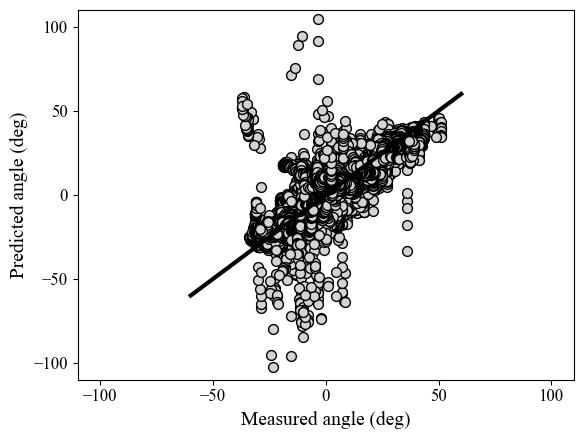

Testing R-squared:  0.8681202093422526
Testing MSE:  32.74908506343731
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                 7.485e+05
Date:                Sun, 28 Sep 2025   Prob (F-statistic):               0.00
Time:                        16:43:37   Log-Likelihood:            -3.4404e+05
No. Observations:              109569   AIC:                         6.881e+05
Df Residuals:                  109567   BIC:                         6.881e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [19]:
# define the input and output of the machine learning algorithm with no autoregressive terms
Y = oos_features[["Pitch","Yaw","Roll"]]
X = oos_features.drop(["Pitch","Yaw","Roll"], axis=1)

# get only columns within optimal lag
x = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))]

# Train linear regression model
oos_predictions = opt_model.predict(x)

# Scatter plot predictions vs. actual angles
plt.scatter(Y[["Pitch"]], oos_predictions, edgecolors='k',c='lightgrey',s=50)
plt.plot([-60, 60], [-60, 60], color='black', lw=3)
plt.ylabel('Predicted angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xlabel('Measured angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xticks([-100, -50, 0, 50, 100], fontsize=12, fontname='Times New Roman')
plt.yticks([-100, -50, 0, 50, 100], fontsize=12, fontname='Times New Roman')
plt.ylim([-110, 110])
plt.xlim([-110, 110])
plt.show()

# Goodness-of-fit
r_squared = r2_score(Y[["Pitch"]], oos_predictions)
print("Testing R-squared: ", r_squared)
mse = mean_squared_error(Y[["Pitch"]], oos_predictions)
print("Testing MSE: ", mse)

# Apply OLS regression to compute confidence intervals and p-values
ols_model = sm.OLS(oos_predictions, sm.add_constant(Y[["Pitch"]]))
ols_results = ols_model.fit()
print(ols_results.summary())


# Train a ridge regression model with various regularization terms

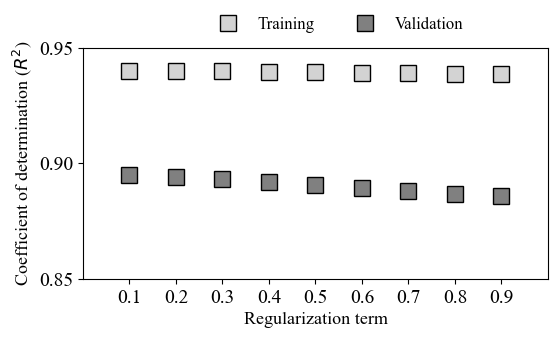

optimal regularization term: 0
0.9400379307777549
0.8948323172578162


In [21]:
# define dataframes for goodness-of-fit
gof_cross_validation = pd.DataFrame(columns=["alpha","r-sq","mse"]) # empty array for calculating mean squared error
gof_training = pd.DataFrame(columns=["alpha","r-sq","mse"]) # empty array for calculating mean squared error

# define the input and output of the machine learning algorithm
Y = training_features[["Pitch","Yaw","Roll"]]
X = training_features.drop(["Pitch","Yaw","Roll"], axis=1)

# get only columns up to optimal lag
x = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))]

# define training and validation data sets
X_train = pd.DataFrame(columns=x.keys())
X_test = pd.DataFrame(columns=x.keys())
Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
for id in np.unique(training_features["User"]):
    X_train = pd.concat([X_train, x[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
    X_test = pd.concat([X_test, x[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])
    Y_train = pd.concat([Y_train, Y[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
    Y_test = pd.concat([Y_test, Y[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])

for a in np.arange(1,10)/10:
    # print("alpha = "+str(a))

    # Train ridge regression model
    rr_model = linear_model.Ridge(alpha=a)
    rr_model.fit(X_train, Y_train[["Pitch"]])
    rr_predictions = rr_model.predict(X_test)
    
    # Compute R-squared and MSE for cross validation
    gof_cross_validation.loc[len(gof_cross_validation)] = [a, r2_score(Y_test[["Pitch"]], rr_predictions), mean_squared_error(Y_test[["Pitch"]], rr_predictions)]
    
    # Compute R-squared and MSE for training
    rr_training_predictions = rr_model.predict(X_train)
    gof_training.loc[len(gof_cross_validation)] = [a, r2_score(Y_train[["Pitch"]], rr_training_predictions), mean_squared_error(Y_train[["Pitch"]], rr_training_predictions)]

# identify the optimal regularization term
plt.figure(figsize=(6,3))
x = np.arange(1,10)/10
y1 = gof_training['r-sq']
y2 = gof_cross_validation['r-sq']
plt.plot(x, y1, 'bs',markersize=12,markerfacecolor='lightgrey',markeredgecolor='black')
plt.plot(x, y2, 'bs',markersize=12,markerfacecolor='grey',markeredgecolor='black')
plt.ylabel(r'Coefficient of determination ($R^2$)', fontsize=13, fontname='Times New Roman')
plt.xlabel('Regularization term', fontsize=13, fontname='Times New Roman')
plt.xticks(np.arange(1,10)/10, fontsize=14, fontname='Times New Roman')
plt.yticks([0.85, 0.9, 0.95], fontsize=14, fontname='Times New Roman')
plt.xlim([0, 1])
plt.ylim([0.85, 0.95])
plt.legend(['Training','Validation'],bbox_to_anchor=(0.85, 1.2), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure9a.pdf')
plt.show()

opt_reg = int(gof_cross_validation[gof_cross_validation["r-sq"]==max(gof_cross_validation["r-sq"])]["alpha"])
print("optimal regularization term: "+str(opt_reg))
print(max(gof_training["r-sq"]))
print(max(gof_cross_validation["r-sq"]))

# Train a lasso regression model with various regularization terms

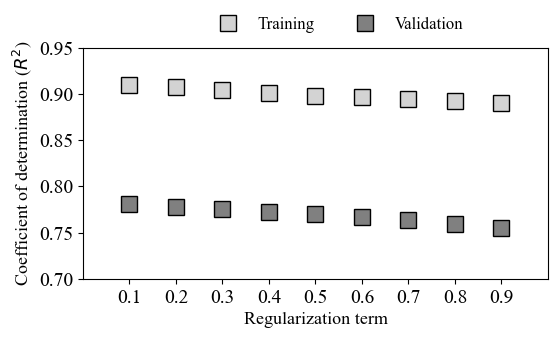

optimal regularization term: 0
0.9095456368650285
0.7807111317588474


In [23]:
# define dataframes for goodness-of-fit
gof_cross_validation = pd.DataFrame(columns=["alpha","r-sq","mse"]) # empty array for calculating mean squared error
gof_training = pd.DataFrame(columns=["alpha","r-sq","mse"]) # empty array for calculating mean squared error

# define the input and output of the machine learning algorithm
Y = training_features[["Pitch","Yaw","Roll"]]
X = training_features.drop(["Pitch","Yaw","Roll"], axis=1)

# get only columns up to optimal lag
x = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))]

# define training and validation data sets
X_train = pd.DataFrame(columns=x.keys())
X_test = pd.DataFrame(columns=x.keys())
Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
for id in np.unique(training_features["User"]):
    X_train = pd.concat([X_train, x[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
    X_test = pd.concat([X_test, x[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])
    Y_train = pd.concat([Y_train, Y[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
    Y_test = pd.concat([Y_test, Y[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])

for a in np.arange(1,10)/10:
    # print("alpha = "+str(a))

    # Train ridge regression model
    lr_model = linear_model.Lasso(alpha=a)
    lr_model.fit(X_train, Y_train[["Pitch"]])
    lr_predictions = lr_model.predict(X_test)
    
    # Compute R-squared and MSE for cross validation
    gof_cross_validation.loc[len(gof_cross_validation)] = [a, r2_score(Y_test[["Pitch"]], lr_predictions), mean_squared_error(Y_test[["Pitch"]], lr_predictions)]
    
    # Compute R-squared and MSE for training
    lr_training_predictions = lr_model.predict(X_train)
    gof_training.loc[len(gof_cross_validation)] = [a, r2_score(Y_train[["Pitch"]], lr_training_predictions), mean_squared_error(Y_train[["Pitch"]], lr_training_predictions)]

# identify the optimal regularization term
plt.figure(figsize=(6,3))
x = np.arange(1,10)/10
y1 = gof_training['r-sq']
y2 = gof_cross_validation['r-sq']
plt.plot(x, y1, 'bs',markersize=12,markerfacecolor='lightgrey',markeredgecolor='black')
plt.plot(x, y2, 'bs',markersize=12,markerfacecolor='grey',markeredgecolor='black')
plt.ylabel(r'Coefficient of determination ($R^2$)', fontsize=13, fontname='Times New Roman')
plt.xlabel('Regularization term', fontsize=13, fontname='Times New Roman')
plt.xticks(np.arange(1,10)/10, fontsize=14, fontname='Times New Roman')
plt.yticks([0.7, 0.75, 0.8, 0.85, 0.9, 0.95], fontsize=14, fontname='Times New Roman')
plt.xlim([0, 1])
plt.ylim([0.7, 0.95])
plt.legend(['Training','Validation'],bbox_to_anchor=(0.85, 1.2), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure9b.pdf')
plt.show()

opt_reg = int(gof_cross_validation[gof_cross_validation["r-sq"]==max(gof_cross_validation["r-sq"])]["alpha"])
print("optimal regularization term: "+str(opt_reg))
print(max(gof_training["r-sq"]))
print(max(gof_cross_validation["r-sq"]))

# Train a decision tree model with various depths

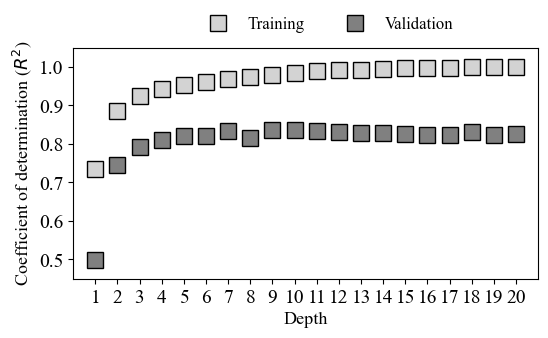

optimal depth: 9
0.9994288540962725
0.8363349996426355


In [25]:
# define structures cross-validations
gof_cross_validation = pd.DataFrame(columns=["depth","r-sq","mse"]) # empty array for goodness-of-fit measurements
gof_training = pd.DataFrame(columns=["depth","r-sq","mse"]) # empty array for goodness-of-fit measurements

# define the input and output of the machine learning algorithm
Y = training_features[["Pitch","Yaw","Roll"]]
X = training_features.drop(["Pitch","Yaw","Roll"], axis=1)

# get only columns without lags
x = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))]

# define training and validation data sets
X_train = pd.DataFrame(columns=x.keys())
X_test = pd.DataFrame(columns=x.keys())
Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
for id in np.unique(training_features["User"]):
    X_train = pd.concat([X_train, x[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
    X_test = pd.concat([X_test, x[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])
    Y_train = pd.concat([Y_train, Y[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
    Y_test = pd.concat([Y_test, Y[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])

for d in np.arange(1,21):
    # print("depth = "+str(d))
        
    # Train linear regression model for pitch
    dt_model = DecisionTreeRegressor(max_depth=d)
    dt_model.fit(X_train, Y_train[["Pitch"]])
    dt_predictions = dt_model.predict(X_test)
    
    # Compute R-squared and MSE for cross validation
    gof_cross_validation.loc[len(gof_cross_validation)] = [d, r2_score(Y_test["Pitch"], dt_predictions), mean_squared_error(Y_test["Pitch"], dt_predictions)]
    
    # Compute R-squared and MSE for training
    dt_training_predictions = dt_model.predict(X_train)
    gof_training.loc[len(gof_cross_validation)] = [d, r2_score(Y_train[["Pitch"]], dt_training_predictions), mean_squared_error(Y_train[["Pitch"]], dt_training_predictions)]

# identify the optimal depth
plt.figure(figsize=(6,3))
x = np.arange(1,21)
y1 = gof_training['r-sq']
y2 = gof_cross_validation['r-sq']
plt.plot(x, y1, 'bs',markersize=12,markerfacecolor='lightgrey',markeredgecolor='black')
plt.plot(x, y2, 'bs',markersize=12,markerfacecolor='grey',markeredgecolor='black')
plt.ylabel(r'Coefficient of determination ($R^2$)', fontsize=13, fontname='Times New Roman')
plt.xlabel('Depth', fontsize=13, fontname='Times New Roman')
plt.xticks(np.arange(1,21), fontsize=14, fontname='Times New Roman')
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1], fontsize=14, fontname='Times New Roman')
plt.xlim([0, 21])
plt.ylim([0.45, 1.05])
plt.legend(['Training','Validation'],bbox_to_anchor=(0.85, 1.2), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure9c.pdf')
plt.show()

opt_depth = int(gof_cross_validation[gof_cross_validation["r-sq"]==max(gof_cross_validation["r-sq"])]["depth"])
print("optimal depth: "+str(opt_depth))
print(max(gof_training["r-sq"]))
print(max(gof_cross_validation["r-sq"]))

# Train a random forest regression model with various forest sizes

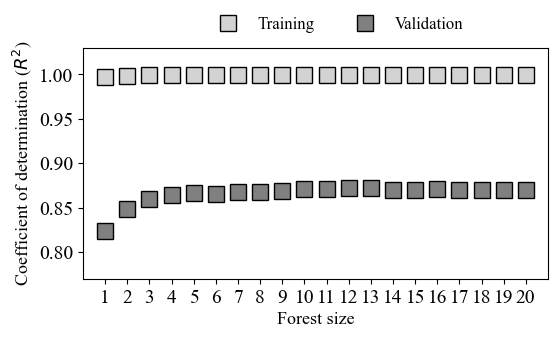

optimal forest size: 12
0.99964725335654
0.8718502684804195
average difference: 0.13381469654966865


In [27]:
# define structures cross-validations
gof_cross_validation = pd.DataFrame(columns=["forest size","r-sq","mse"]) # empty array for goodness-of-fit measurements
gof_training = pd.DataFrame(columns=["forest size","r-sq","mse"]) # empty array for goodness-of-fit measurements

# define the input and output of the machine learning algorithm
Y = training_features[["Pitch","Yaw","Roll"]]
X = training_features.drop(["Pitch","Yaw","Roll"], axis=1)

# get only columns without lags
x = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))]

# define training and validation data sets
X_train = pd.DataFrame(columns=x.keys())
X_test = pd.DataFrame(columns=x.keys())
Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
for id in np.unique(training_features["User"]):
    X_train = pd.concat([X_train, x[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
    X_test = pd.concat([X_test, x[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])
    Y_train = pd.concat([Y_train, Y[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
    Y_test = pd.concat([Y_test, Y[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])

for fs in np.arange(1,21):
    # print("forest size = "+str(fs))
        
    # Train linear regression model for pitch
    fs_model = RandomForestRegressor(n_estimators=fs, random_state=0, oob_score=True)
    fs_model.fit(X_train,Y_train[["Pitch"]])
    fs_predictions = fs_model.predict(X_test)
    
    # Compute R-squared and MSE for cross validation
    gof_cross_validation.loc[len(gof_cross_validation)] = [fs, r2_score(Y_test["Pitch"], fs_predictions), mean_squared_error(Y_test["Pitch"], fs_predictions)]
    
    # Compute R-squared and MSE for training
    fs_training_predictions = fs_model.predict(X_train)
    gof_training.loc[len(gof_cross_validation)] = [fs, r2_score(Y_train[["Pitch"]], fs_training_predictions), mean_squared_error(Y_train[["Pitch"]], fs_training_predictions)]

# identify the optimal lag
plt.figure(figsize=(6,3))
x = np.arange(1,fs+1)
y1 = gof_training['r-sq']
y2 = gof_cross_validation['r-sq']
plt.plot(x, y1, 'bs',markersize=12,markerfacecolor='lightgrey',markeredgecolor='black')
plt.plot(x, y2, 'bs',markersize=12,markerfacecolor='grey',markeredgecolor='black')
plt.ylabel(r'Coefficient of determination ($R^2$)', fontsize=13, fontname='Times New Roman')
plt.xlabel('Forest size', fontsize=13, fontname='Times New Roman')
plt.xticks(np.arange(1,21), fontsize=14, fontname='Times New Roman')
plt.yticks([0.8, 0.85, 0.9, 0.95, 1.0], fontsize=14, fontname='Times New Roman')
plt.xlim([0, fs+1])
plt.ylim([0.77, 1.03])
plt.legend(['Training','Validation'],bbox_to_anchor=(0.85, 1.2), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure9d.pdf')
plt.show()

opt_fs = int(gof_cross_validation[gof_cross_validation["r-sq"]==max(gof_cross_validation["r-sq"])]["forest size"])
print("optimal forest size: "+str(opt_fs))
print(max(gof_training["r-sq"]))
print(max(gof_cross_validation["r-sq"]))
print("average difference: "+str(np.mean(gof_training["r-sq"].reset_index(drop=True)-gof_cross_validation["r-sq"])))


# Apply statistical tests to understand sources of error

### add features on out-of-sample users into a single dataframe

In [30]:
# Iterate over each user folder
for user_id, user_folder in enumerate(oos_user_folders, start=0):
    user_data_folder = os.path.join(oos_data_folder, user_folder)
    # print("user "+str(user_id))
    # print(user_data_folder)

    # Load CSV files for each user
    df_falcon = pd.read_csv(os.path.join(user_data_folder, "novint-falcon.csv"))
    df_falcon = df_falcon.rename(columns={'global time': 'Time'}) # rename time column for consistency
    df_imu = pd.read_csv(os.path.join(user_data_folder, "imu.csv"))
    df_angles = pd.read_csv(os.path.join(user_data_folder, "wrist-angles.csv"))
    df_img = pd.read_csv(os.path.join(user_data_folder, "IMG_2 (Instance).csv"))
    
    # Convert time columns to datetime format
    df_falcon['Time'] = pd.to_datetime(df_falcon['Time'].str.strip(), format='%H:%M:%S.%f')
    df_imu['Time'] = pd.to_datetime(df_imu['Time'])
    df_angles['Time'] = pd.to_datetime(df_angles['Time'].str.strip(), format='%I:%M:%S.%f %p')

    # Extract the time from the first row of df_img
    start_time_img = df_img.iloc[0][' time (s)']

    # Find the index of the exact time in df_falcon
    exact_index_falcon = df_falcon[df_falcon[' time (s)'] == start_time_img].index[0]

    # Slice df_falcon from the exact index
    df_falcon = df_falcon.iloc[exact_index_falcon:].reset_index(drop=True)

    # Calculate the time difference for df_angles and df_imu
    time_diff_angles = abs(df_angles['Time'] - df_falcon.iloc[0]['Time'])
    time_diff_imu = abs(df_imu['Time'] - df_falcon.iloc[0]['Time'])

    # Find the index of the minimum time difference
    nearest_index_angles = time_diff_angles.idxmin()
    nearest_index_imu = time_diff_imu.idxmin()
    
    # Slice df_angles and df_imu from the nearest index
    df_angles = df_angles.iloc[nearest_index_angles:].reset_index()
    df_imu = df_imu.iloc[nearest_index_imu:].reset_index()

    # # Number of raw observsations in each dataset
    # print("falcon observations = "+str(np.shape(df_falcon)[0]))
    # print("imu observations = "+str(np.shape(df_imu)[0]))
    
    # Subset only columns relevant for training
    df_falcon = df_falcon.drop([' time (s)',' rotation_x',' rotation_y'], axis=1)
    df_imu.drop(list(df_imu.filter(regex='2')), axis=1, inplace=True) # remove anything with IMU2 that is placed on the back of the hand

    # Downsample the falcon data
    df_falcon_downsampled = pd.DataFrame(columns=df_falcon.keys())
    for ts in np.arange(len(df_angles)):
        min_index = abs(df_angles.iloc[ts]['Time'] - df_falcon['Time']).idxmin()
        df_falcon_downsampled.loc[len(df_falcon_downsampled.index)] = df_falcon.iloc[min_index-2:min_index+3][[' falcon_x',' falcon_y',' falcon_z']].mean()
    df_falcon = pd.concat([df_angles['Time'],df_falcon_downsampled.drop('Time', axis=1).reset_index(drop=True)], axis=1)

    # remove drift from IMU1 yaw
    m,b = np.polyfit(np.arange(np.shape(df_imu)[0]), df_imu["Yaw1"], 1)
    df_imu["Yaw1"] = df_imu["Yaw1"]-(m*np.arange(np.shape(df_imu)[0])+b)    
    
    # apply a median filter on all raw data
    df_angles["Roll"] = signal.medfilt(df_angles["Roll"],kernel_size=window_size)
    df_angles["Pitch"] = signal.medfilt(df_angles["Pitch"],kernel_size=window_size)
    df_angles["Yaw"] = signal.medfilt(df_angles["Yaw"],kernel_size=window_size)
    df_falcon[" falcon_x"] = signal.medfilt(df_falcon[" falcon_x"],kernel_size=window_size)
    df_falcon[" falcon_y"] = signal.medfilt(df_falcon[" falcon_y"],kernel_size=window_size)
    df_falcon[" falcon_z"] = signal.medfilt(df_falcon[" falcon_z"],kernel_size=window_size)
    df_imu["Yaw1"] = signal.medfilt(df_imu["Yaw1"],kernel_size=window_size)
    df_imu["Pitch1"] = signal.medfilt(df_imu["Pitch1"],kernel_size=window_size)
    df_imu["Roll1"] = signal.medfilt(df_imu["Roll1"],kernel_size=window_size)
    df_imu["AccX1"] = signal.medfilt(df_imu["AccX1"],kernel_size=window_size)
    df_imu["AccY1"] = signal.medfilt(df_imu["AccY1"],kernel_size=window_size)
    df_imu["AccZ1"] = signal.medfilt(df_imu["AccZ1"],kernel_size=window_size)
    df_imu["RotX1"] = signal.medfilt(df_imu["RotX1"],kernel_size=window_size)
    df_imu["RotY1"] = signal.medfilt(df_imu["RotY1"],kernel_size=window_size)
    df_imu["RotZ1"] = signal.medfilt(df_imu["RotZ1"],kernel_size=window_size)

    # add time derivatives in falcon data
    df_falcon["falcon_x_dot"] = df_falcon[" falcon_x"]
    df_falcon["falcon_y_dot"] = df_falcon[" falcon_y"]
    df_falcon["falcon_z_dot"] = df_falcon[" falcon_z"]
    for ts in np.arange(((window_size-1)/2),len(df_falcon)-((window_size-1)/2)):
        df_falcon.loc[ts, 'falcon_x_dot'] = (df_falcon[" falcon_x"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_x"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_falcon.loc[ts, 'falcon_y_dot'] = (df_falcon[" falcon_y"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_y"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_falcon.loc[ts, 'falcon_z_dot'] = (df_falcon[" falcon_z"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_z"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()

    # add time integrals in IMU data
    df_imu["VelX1"] = df_imu["AccX1"]
    df_imu["VelY1"] = df_imu["AccY1"]
    df_imu["VelZ1"] = df_imu["AccZ1"]    
    for ts in np.arange(((window_size-1)/2),len(df_imu)-((window_size-1)/2)):
        df_imu.loc[ts,'VelX1'] = (df_imu["AccX1"].loc[ts+((window_size-1)/2)]-df_imu["AccX1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'VelY1'] = (df_imu["AccY1"].loc[ts+((window_size-1)/2)]-df_imu["AccY1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'VelZ1'] = (df_imu["AccZ1"].loc[ts+((window_size-1)/2)]-df_imu["AccZ1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
    
    # add time integrals in IMU data
    df_imu["PosX1"] = df_imu["AccX1"]
    df_imu["PosY1"] = df_imu["AccY1"]
    df_imu["PosZ1"] = df_imu["AccZ1"]    
    for ts in np.arange(((window_size-1)/2),len(df_imu)-((window_size-1)/2)):
        df_imu.loc[ts,'PosX1'] = (df_imu["VelX1"].loc[ts+((window_size-1)/2)]-df_imu["VelX1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'PosY1'] = (df_imu["VelY1"].loc[ts+((window_size-1)/2)]-df_imu["VelY1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
        df_imu.loc[ts,'PosZ1'] = (df_imu["VelZ1"].loc[ts+((window_size-1)/2)]-df_imu["VelZ1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()

    # add features from the kinematic model
    df_imu["sin(Pitch1)"] = np.sin(df_imu["Pitch1"].astype(float).apply(math.radians))
    df_imu["sin(Yaw1)"] = np.sin(df_imu["Yaw1"].astype(float).apply(math.radians))
    df_imu["sin(Roll1)"] = np.sin(df_imu["Roll1"].astype(float).apply(math.radians))
    df_imu["cos(Pitch1)"] = np.cos(df_imu["Pitch1"].astype(float).apply(math.radians))
    df_imu["cos(Yaw1)"] = np.cos(df_imu["Yaw1"].astype(float).apply(math.radians))
    df_imu["cos(Roll1)"] = np.cos(df_imu["Roll1"].astype(float).apply(math.radians))
    df_imu["RotX1*sin(Pitch1)"] = df_imu["RotX1"]*df_imu["sin(Pitch1)"]
    df_imu["RotY1*sin(Pitch1)"] = df_imu["RotY1"]*df_imu["sin(Pitch1)"]
    df_imu["RotZ1*sin(Pitch1)"] = df_imu["RotZ1"]*df_imu["sin(Pitch1)"]
    df_imu["RotX1*sin(Yaw1)"] = df_imu["RotX1"]*df_imu["sin(Yaw1)"]
    df_imu["RotY1*sin(Yaw1)"] = df_imu["RotY1"]*df_imu["sin(Yaw1)"]
    df_imu["RotZ1*sin(Yaw1)"] = df_imu["RotZ1"]*df_imu["sin(Yaw1)"]
    df_imu["RotX1*sin(Roll1)"] = df_imu["RotX1"]*df_imu["sin(Roll1)"]
    df_imu["RotY1*sin(Roll1)"] = df_imu["RotY1"]*df_imu["sin(Roll1)"]
    df_imu["RotZ1*sin(Roll1)"] = df_imu["RotZ1"]*df_imu["sin(Roll1)"]
    df_imu["RotX1*cos(Pitch1)"] = df_imu["RotX1"]*df_imu["cos(Pitch1)"]
    df_imu["RotY1*cos(Pitch1)"] = df_imu["RotY1"]*df_imu["cos(Pitch1)"]
    df_imu["RotZ1*cos(Pitch1)"] = df_imu["RotZ1"]*df_imu["cos(Pitch1)"]
    df_imu["RotX1*cos(Yaw1)"] = df_imu["RotX1"]*df_imu["cos(Yaw1)"]
    df_imu["RotY1*cos(Yaw1)"] = df_imu["RotY1"]*df_imu["cos(Yaw1)"]
    df_imu["RotZ1*cos(Yaw1)"] = df_imu["RotZ1"]*df_imu["cos(Yaw1)"]
    df_imu["RotX1*cos(Roll1)"] = df_imu["RotX1"]*df_imu["cos(Roll1)"]
    df_imu["RotY1*cos(Roll1)"] = df_imu["RotY1"]*df_imu["cos(Roll1)"]
    df_imu["RotZ1*cos(Roll1)"] = df_imu["RotZ1"]*df_imu["cos(Roll1)"]
    df_imu["arctan"] = np.arctan(np.nan_to_num(((-df_imu["VelX1"]+df_falcon["falcon_x_dot"]-L*df_imu["RotY1"]*df_imu["sin(Pitch1)"])/(df_imu["VelY1"]-df_falcon["falcon_y_dot"]+L*df_imu["RotY1"]*df_imu["cos(Pitch1)"])).apply(math.radians)))+df_imu["Pitch1"]

    # apply a median filter on computed values
    df_falcon["falcon_x_dot"] = signal.medfilt(df_falcon["falcon_x_dot"],kernel_size=window_size)
    df_falcon["falcon_y_dot"] = signal.medfilt(df_falcon["falcon_y_dot"],kernel_size=window_size)
    df_falcon["falcon_z_dot"] = signal.medfilt(df_falcon["falcon_z_dot"],kernel_size=window_size)
    df_imu["VelX1"] = signal.medfilt(df_imu["VelX1"],kernel_size=window_size)
    df_imu["VelY1"] = signal.medfilt(df_imu["VelY1"],kernel_size=window_size)
    df_imu["VelZ1"] = signal.medfilt(df_imu["VelZ1"],kernel_size=window_size)
    df_imu["PosX1"] = signal.medfilt(df_imu["PosX1"],kernel_size=window_size)
    df_imu["PosY1"] = signal.medfilt(df_imu["PosY1"],kernel_size=window_size)
    df_imu["PosZ1"] = signal.medfilt(df_imu["PosZ1"],kernel_size=window_size)
    df_imu["sin(Pitch1)"] = signal.medfilt(df_imu["sin(Pitch1)"],kernel_size=window_size)
    df_imu["sin(Yaw1)"] = signal.medfilt(df_imu["sin(Yaw1)"],kernel_size=window_size)
    df_imu["sin(Roll1)"] = signal.medfilt(df_imu["sin(Roll1)"],kernel_size=window_size)
    df_imu["cos(Pitch1)"] = signal.medfilt(df_imu["cos(Pitch1)"],kernel_size=window_size)
    df_imu["cos(Yaw1)"] = signal.medfilt(df_imu["cos(Yaw1)"],kernel_size=window_size)
    df_imu["cos(Roll1)"] = signal.medfilt(df_imu["cos(Roll1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Pitch1)"] = signal.medfilt(df_imu["RotX1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Pitch1)"] = signal.medfilt(df_imu["RotY1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Pitch1)"] = signal.medfilt(df_imu["RotZ1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Yaw1)"] = signal.medfilt(df_imu["RotX1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Yaw1)"] = signal.medfilt(df_imu["RotY1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Yaw1)"] = signal.medfilt(df_imu["RotZ1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Roll1)"] = signal.medfilt(df_imu["RotX1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Roll1)"] = signal.medfilt(df_imu["RotY1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Roll1)"] = signal.medfilt(df_imu["RotZ1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Pitch1)"] = signal.medfilt(df_imu["RotX1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Pitch1)"] = signal.medfilt(df_imu["RotY1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Pitch1)"] = signal.medfilt(df_imu["RotZ1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Yaw1)"] = signal.medfilt(df_imu["RotX1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Yaw1)"] = signal.medfilt(df_imu["RotY1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Yaw1)"] = signal.medfilt(df_imu["RotZ1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Roll1)"] = signal.medfilt(df_imu["RotX1*cos(Roll1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Roll1)"] = signal.medfilt(df_imu["RotY1*cos(Roll1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Roll1)"] = signal.medfilt(df_imu["RotZ1*cos(Roll1)"],kernel_size=window_size)
    df_imu["arctan"] = signal.medfilt(df_imu["arctan"],kernel_size=window_size)

    # change the time colmns to index to merge time series into a single dataframe
    df_angles = df_angles.set_index(['Time'])
    df_falcon = df_falcon.set_index(['Time'])
    df_imu = df_imu.set_index(['Time'])
    
    # # print the lenth of the interaction in time
    # print("falcon observations = "+str(np.shape(df_falcon)[0]))
    # print("duration = "+str(df_imu.reset_index()["Time"][np.shape(df_imu)[0]-1]-df_imu.reset_index()["Time"][0]))

    # Merge time series into a single dataframe
    df_data = pd.merge(df_angles, df_falcon, left_index=True, right_index=True)
    df_data = pd.merge(df_data, df_imu, left_index=True, right_index=True)

    # Revert index back to numerics
    df_data = df_data.reset_index(drop=True)
    
    # Lag the merged data
    df_data = time_embed(df_data, lag)

    # remove rows with NaN values
    df_data = df_data.dropna()

    # Add user ID column
    user_id = float(user_data_folder[-2:])
    df_data['User'] = user_id

    # compute user's range of motion and entropy along yaw, pitch, and roll
    wrist_rom.loc[len(wrist_rom)] = [user_id,
                                 max(df_data.Yaw)-min(df_data.Yaw),
                                 max(df_data.Pitch)-min(df_data.Pitch)]
    
    wrist_variance.loc[len(wrist_variance)] = [user_id,
                                 np.var(df_data.Yaw),
                                 np.var(df_data.Pitch)]
    
    wrist_entropy.loc[len(wrist_entropy)] = [user_id,
                                 -np.nansum(np.histogram(df_data["Yaw"],yaw_bins)[0]/np.sum(np.histogram(df_data["Yaw"],yaw_bins)[0])*np.log10(np.histogram(df_data["Yaw"],yaw_bins)[0]/np.sum(np.histogram(df_data["Yaw"],yaw_bins)[0]))),
                                 -np.nansum(np.histogram(df_data["Pitch"],pitch_bins)[0]/np.sum(np.histogram(df_data["Pitch"],pitch_bins)[0])*np.log10(np.histogram(df_data["Pitch"],pitch_bins)[0]/np.sum(np.histogram(df_data["Pitch"],pitch_bins)[0])))]

    # Append to the list of DataFrames
    dfs.append(df_data)

# Convert the dataframes into a pandas dataframe
features = pd.concat(dfs)

# remove irrelevant columns
features.drop(list(features.filter(regex='index')), axis=1, inplace=True)
features.drop(list(features.filter(regex='Roll_Lag:')), axis=1, inplace=True)
features.drop(list(features.filter(regex='Pitch_Lag:')), axis=1, inplace=True)
features.drop(list(features.filter(regex='Yaw_Lag:')), axis=1, inplace=True)
features.drop(list(features.filter(regex='Unnamed')), axis=1, inplace=True)

features = features.drop_duplicates()


### Compute model accuracy for each user

In [32]:
wrist_rom = wrist_rom[1:20] # remove user 0 (author of the paper)
indiv_user_errors = pd.DataFrame(columns=["User","Pitch","Prediction","Squared Error"]) # define a dataframe to compute individual user error
X = features.iloc[:,list(range(0, num_vars*(opt_lag+1)+3))] # define input for the machine learning algorithm up to the optimal lag
X["User"] = features["User"] # put back user IDs in the features dataframe
X = X[X['User'].isin([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])] # remove user 0 (author of the paper)
indiv_user_errors["User"] = X["User"] # record user IDs
indiv_user_errors["Pitch"] = X["Pitch"] # record ground truth measurements
X = X.drop(["Pitch","Yaw","Roll"], axis=1) # remove the outcome variables from 
all_predictions = opt_model.predict(X.drop(["User"], axis=1)) # get predictions of the wrist angle 
indiv_user_errors["Prediction"] = all_predictions.tolist() # record ground truth measurements
indiv_user_errors.reset_index(inplace=True) 
indiv_user_errors["Prediction"] = [indiv_user_errors["Prediction"][x][0] for x in np.arange(np.shape(indiv_user_errors)[0])] # record predictions
indiv_user_errors["Squared Error"] = (indiv_user_errors["Pitch"]-indiv_user_errors["Prediction"])**2 # compute the squared error

user_accuracy = pd.DataFrame(columns=["User","ROM","MSE","N"]) # define a dataframe to compute individual user error
user_accuracy["User"] = wrist_rom["user"]
user_accuracy["ROM"] = wrist_rom["pitch"]    
user_accuracy["Variance"] = wrist_variance["pitch"]    
user_accuracy["Entropy"] = wrist_entropy["pitch"]    
user_accuracy["N"] = [len(indiv_user_errors[indiv_user_errors["User"] == user_id]) for user_id in user_accuracy["User"]]
user_accuracy["MSE"] = [sum(indiv_user_errors[indiv_user_errors["User"] == user_id]["Squared Error"])/len(indiv_user_errors[indiv_user_errors["User"] == user_id]["Squared Error"]) for user_id in user_accuracy["User"]]


### Plot error a function of range of motion

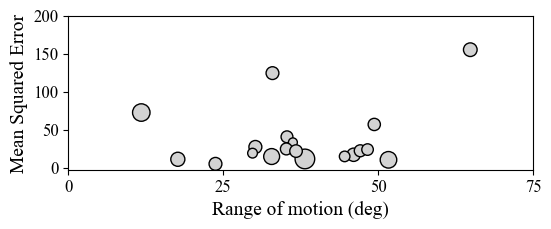

In [34]:
fig = plt.figure(figsize=(6, 2))
plt.scatter(user_accuracy[["ROM"]], user_accuracy[["MSE"]], edgecolors='k',c='lightgrey',s=200*user_accuracy[["N"]]/max(user_accuracy["N"]))
plt.ylabel('Mean Squared Error', fontsize=14, fontname='Times New Roman')
plt.xlabel('Range of motion (deg)', fontsize=14, fontname='Times New Roman')
plt.xticks([0, 25, 50, 75], fontsize=12, fontname='Times New Roman')
plt.yticks([0, 50, 100, 150, 200], fontsize=12, fontname='Times New Roman')
# plt.savefig('Figure7a.pdf')
plt.show()


### Plot error a function of angle variance

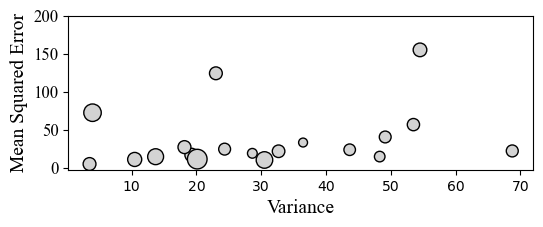

In [36]:
fig = plt.figure(figsize=(6, 2))
plt.scatter(user_accuracy[["Variance"]], user_accuracy[["MSE"]], edgecolors='k',c='lightgrey',s=200*user_accuracy[["N"]]/max(user_accuracy["N"]))
plt.ylabel('Mean Squared Error', fontsize=14, fontname='Times New Roman')
plt.xlabel('Variance', fontsize=14, fontname='Times New Roman')
# plt.xticks([0, 0.5, 1.0, 1.5], fontsize=12, fontname='Times New Roman')
plt.yticks([0, 50, 100, 150, 200], fontsize=12, fontname='Times New Roman')
# plt.savefig('Figure7b.pdf')
plt.show()


### Plot error a function of angle entropy

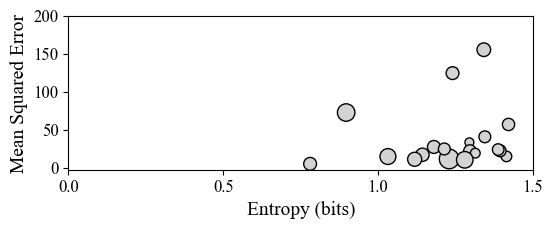

In [38]:
# Scatter plot of error vs. entropy
fig = plt.figure(figsize=(6, 2))
plt.scatter(user_accuracy[["Entropy"]], user_accuracy[["MSE"]], edgecolors='k',c='lightgrey',s=200*user_accuracy[["N"]]/max(user_accuracy["N"]))
plt.ylabel('Mean Squared Error', fontsize=14, fontname='Times New Roman')
plt.xlabel('Entropy (bits)', fontsize=14, fontname='Times New Roman')
plt.xticks([0, 0.5, 1.0, 1.5], fontsize=12, fontname='Times New Roman')
plt.yticks([0, 50, 100, 150, 200], fontsize=12, fontname='Times New Roman')
# plt.savefig('Figure7a.pdf')
plt.show()


## Train a model excluding data from the users with the highest MSE

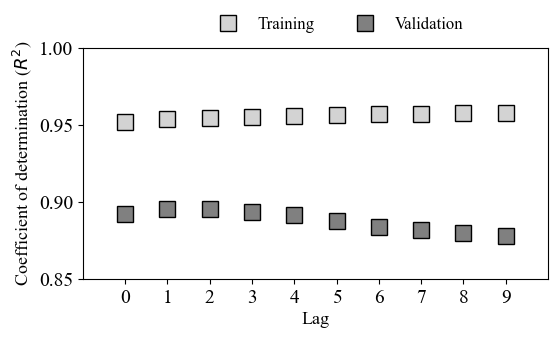

0.9577412235772378
0.8952864043234655
average difference: 0.0678815387570747
R-squared for training with lag 2: 0.9536878669664404
R-squared for validation with lag 2: 0.8950404135336993


In [40]:
# define structures for cross-validations
num_vars = np.shape(df_falcon.drop(list(df_falcon.filter(regex='index')), axis=1))[1] + np.shape(df_imu.drop(list(df_imu.filter(regex='index')), axis=1))[1]-1
gof_cross_validation = pd.DataFrame(columns=["lag","r-sq","mse"]) # empty array for goodness-of-fit measurements
gof_training = pd.DataFrame(columns=["lag","r-sq","mse"]) # empty array for goodness-of-fit measurements

# define the input and output of the machine learning algorithm
training_features = features[features['User'].isin([2,3,4,5,6,7,8,9,10,12,13,15,16,17])] # remove users 1, 11, and 14 with the greatest MSE
Y = training_features[["Pitch","Yaw","Roll"]]
X = training_features.drop(["Pitch","Yaw","Roll"], axis=1)

# iterate throught lags
for l in np.arange(lag+1):
    # print("lag "+str(l))
    
    # get only columns up to lag l
    x = X.iloc[:,list(range(0, num_vars*(l+1)))]

    # define training and validation data sets
    X_train = pd.DataFrame(columns=x.keys())
    X_test = pd.DataFrame(columns=x.keys())
    Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
    Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
    for id in np.unique(features["User"]):
        X_train = pd.concat([X_train, x[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
        X_test = pd.concat([X_test, x[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])
        Y_train = pd.concat([Y_train, Y[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
        Y_test = pd.concat([Y_test, Y[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])
        
    # Train linear regression model for pitch
    model = LinearRegression()
    model.fit(X_train,Y_train[["Pitch"]])
    predictions = model.predict(X_test) 
    
    # Compute R-squared and MSE for cross validation
    gof_cross_validation.loc[len(gof_cross_validation)] = [l, r2_score(Y_test[["Pitch"]], predictions), mean_squared_error(Y_test[["Pitch"]], predictions)]
    
    # Compute R-squared and MSE for training
    training_predictions = model.predict(X_train)
    gof_training.loc[len(gof_cross_validation)] = [l, r2_score(Y_train[["Pitch"]], training_predictions), mean_squared_error(Y_train[["Pitch"]], training_predictions)]

# identify the optimal lag
plt.figure(figsize=(6,3))
x = np.arange(lag+1)
y1 = gof_training['r-sq']
y2 = gof_cross_validation['r-sq']
plt.plot(x, y1, 'bs',markersize=12,markerfacecolor='lightgrey',markeredgecolor='black')
plt.plot(x, y2, 'bs',markersize=12,markerfacecolor='grey',markeredgecolor='black')
plt.ylabel(r'Coefficient of determination ($R^2$)', fontsize=13, fontname='Times New Roman')
plt.xlabel('Lag', fontsize=13, fontname='Times New Roman')
plt.xticks(np.arange(0,10), fontsize=14, fontname='Times New Roman')
plt.yticks([0.85, 0.9, 0.95, 1.0], fontsize=14, fontname='Times New Roman')
plt.xlim([-1, lag+1])
plt.ylim([0.85, 1.0])
plt.legend(['Training','Validation'],bbox_to_anchor=(0.85, 1.2), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure7c.pdf')
plt.show()

print(max(gof_training["r-sq"]))
print(max(gof_cross_validation["r-sq"]))
print("average difference: "+str(np.mean(gof_training["r-sq"].reset_index(drop=True)-gof_cross_validation["r-sq"])))
print("R-squared for training with lag 2: "+str(gof_training["r-sq"][2]))
print("R-squared for validation with lag 2: "+str(gof_cross_validation["r-sq"][2]))


# Train a model in the absence of data from the Novint Falcon to ensure that it has some predictive value

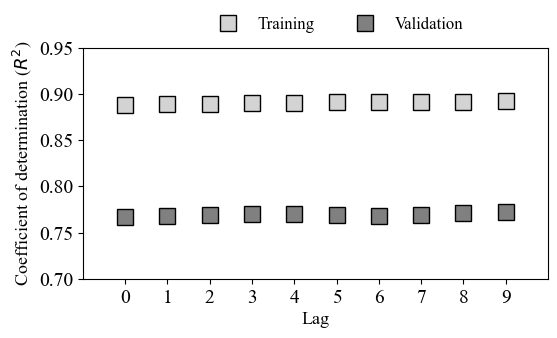

R-squared for training: 3    0.889345
Name: r-sq, dtype: float64
R-squared for validation: 2    0.769194
Name: r-sq, dtype: float64


In [42]:
# filter the columns with data from the novint falcon
features_imu = features.drop(list(features.filter(regex='sin')), axis=1)
features_imu = features_imu.drop(list(features_imu.filter(regex='cos')), axis=1)
features_imu = features_imu.drop(list(features_imu.filter(regex='arc')), axis=1)
features_imu = features_imu.drop(list(features_imu.filter(regex='falcon')), axis=1)

# define structures for cross-validations
gof_cross_validation = pd.DataFrame(columns=["lag","r-sq","mse"]) # empty array for goodness-of-fit measurements
gof_training = pd.DataFrame(columns=["lag","r-sq","mse"]) # empty array for goodness-of-fit measurements

# define the input and output of the machine learning algorithm
training_features = features_imu[features_imu['User'].isin([1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17])] # remove user 0 (author of the paper)
num_vars = np.shape(training_features.filter(regex='Lag:9'))[1]
Y = training_features[["Pitch","Yaw","Roll"]]
X = training_features.drop(["Pitch","Yaw","Roll"], axis=1)

# iterate throught lags
for l in np.arange(lag+1):
    # print("lag "+str(l))
    
    # get only columns up to lag l
    Xl = X.iloc[:,list(range(0, num_vars*(l+1)))]

    # define training and validation data sets
    X_train = pd.DataFrame(columns=Xl.keys())
    X_test = pd.DataFrame(columns=Xl.keys())
    Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
    Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
    for id in np.unique(features["User"]):
        X_train = pd.concat([X_train, Xl[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
        X_test = pd.concat([X_test, Xl[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])
        Y_train = pd.concat([Y_train, Y[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
        Y_test = pd.concat([Y_test, Y[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])

    
    # Train linear regression model for pitch
    model = LinearRegression()
    model.fit(X_train,Y_train[["Pitch"]])
    predictions = model.predict(X_test) 
    
    # Compute R-squared and MSE for cross validation
    gof_cross_validation.loc[len(gof_cross_validation)] = [l, r2_score(Y_test[["Pitch"]], predictions), mean_squared_error(Y_test[["Pitch"]], predictions)]
    
    # Compute R-squared and MSE for training
    training_predictions = model.predict(X_train)
    gof_training.loc[len(gof_cross_validation)] = [l, r2_score(Y_train[["Pitch"]], training_predictions), mean_squared_error(Y_train[["Pitch"]], training_predictions)]

# identify the optimal lag
plt.figure(figsize=(6,3))
x = np.arange(lag+1)
y1 = gof_training['r-sq']
y2 = gof_cross_validation['r-sq']
plt.plot(x, y1, 'bs',markersize=12,markerfacecolor='lightgrey',markeredgecolor='black')
plt.plot(x, y2, 'bs',markersize=12,markerfacecolor='grey',markeredgecolor='black')
plt.ylabel(r'Coefficient of determination ($R^2$)', fontsize=13, fontname='Times New Roman')
plt.xlabel('Lag', fontsize=13, fontname='Times New Roman')
plt.xticks(np.arange(0,10), fontsize=14, fontname='Times New Roman')
plt.yticks([0.7, 0.75,0.8,0.85, 0.9, 0.95], fontsize=14, fontname='Times New Roman')
plt.xlim([-1, lag+1])
plt.ylim([0.7, 0.95])
plt.legend(['Training','Validation'],bbox_to_anchor=(0.85, 1.2), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure5a.pdf')
plt.show()

print("R-squared for training: "+str(gof_training[gof_training["lag"]==2]["r-sq"]))
print("R-squared for validation: "+str(gof_cross_validation[gof_cross_validation["lag"]==2]["r-sq"]))


# Train a model in the absence of data from the IMU to ensure that it has some predictive value

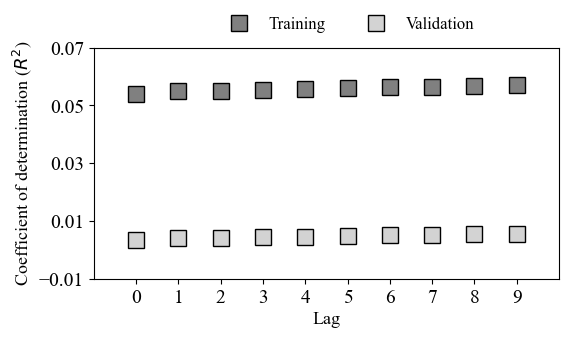

R-squared for training: 3    0.004217
Name: r-sq, dtype: float64
R-squared for validation: 2    0.055119
Name: r-sq, dtype: float64


In [44]:
# filter the columns with data from the novint falcon
features_falcon = features[list(features.filter(regex='falcon'))]
features_falcon["User"]=features["User"]
features_falcon["Roll"]=features["Roll"]
features_falcon["Pitch"]=features["Pitch"]
features_falcon["Yaw"]=features["Yaw"]

# define structures for cross-validations
gof_cross_validation = pd.DataFrame(columns=["lag","r-sq","mse"]) # empty array for goodness-of-fit measurements
gof_training = pd.DataFrame(columns=["lag","r-sq","mse"]) # empty array for goodness-of-fit measurements

# define the input and output of the machine learning algorithm
training_features = features_falcon[features_falcon['User'].isin([1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17])] # remove user 0 (author of the paper)
num_vars = np.shape(training_features.filter(regex='Lag:9'))[1]
Y = training_features[["Pitch","Yaw","Roll"]]
X = training_features.drop(["Pitch","Yaw","Roll"], axis=1)

# iterate throught lags
for l in np.arange(lag+1):
    # print("lag "+str(l))
    
    # get only columns up to lag l
    Xl = X.iloc[:,list(range(0, num_vars*(l+1)))]

    # define training and validation data sets
    X_train = pd.DataFrame(columns=Xl.keys())
    X_test = pd.DataFrame(columns=Xl.keys())
    Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
    Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
    for id in np.unique(features["User"]):
        X_train = pd.concat([X_train, Xl[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
        X_test = pd.concat([X_test, Xl[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])
        Y_train = pd.concat([Y_train, Y[training_features["User"]==id][:round(K*len(training_features[training_features["User"]==id]))]])
        Y_test = pd.concat([Y_test, Y[training_features["User"]==id][round(K*len(training_features[training_features["User"]==id])):]])

    
    # Train linear regression model for pitch
    model = LinearRegression()
    model.fit(X_train,Y_train[["Pitch"]])
    predictions = model.predict(X_test) 
    
    # Compute R-squared and MSE for cross validation
    gof_cross_validation.loc[len(gof_cross_validation)] = [l, abs(r2_score(Y_test[["Pitch"]], predictions)), mean_squared_error(Y_test[["Pitch"]], predictions)]
    
    # Compute R-squared and MSE for training
    training_predictions = model.predict(X_train)
    gof_training.loc[len(gof_cross_validation)] = [l, r2_score(Y_train[["Pitch"]], training_predictions), mean_squared_error(Y_train[["Pitch"]], training_predictions)]

# identify the optimal lag
plt.figure(figsize=(6,3))
x = np.arange(lag+1)
y1 = gof_training['r-sq']
y2 = gof_cross_validation['r-sq']
plt.plot(x, y2, 'bs',markersize=12,markerfacecolor='grey',markeredgecolor='black')
plt.plot(x, y1, 'bs',markersize=12,markerfacecolor='lightgrey',markeredgecolor='black')
plt.ylabel(r'Coefficient of determination ($R^2$)', fontsize=13, fontname='Times New Roman')
plt.xlabel('Lag', fontsize=13, fontname='Times New Roman')
plt.xticks(np.arange(0,10), fontsize=14, fontname='Times New Roman')
plt.yticks([-0.01, 0.01, 0.03, 0.05, 0.07], fontsize=14, fontname='Times New Roman')
plt.xlim([-1, lag+1])
plt.ylim([-0.01, 0.07])
plt.legend(['Training','Validation'],bbox_to_anchor=(0.85, 1.2), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure5a.pdf')
plt.show()

print("R-squared for training: "+str(gof_training[gof_training["lag"]==2]["r-sq"]))
print("R-squared for validation: "+str(gof_cross_validation[gof_cross_validation["lag"]==2]["r-sq"]))


# Illustrate user interaction with the Novint Falcon

### Read data on the movement of the first user

In [47]:
dps = [] # Create an empty list to store observations in

user_id =0
user_data_folder = training_data_folder+"/User-"+str(user_id)
print( "user "+str(user_id))
print(user_data_folder)

# Load CSV files for each user
df_falcon = pd.read_csv(os.path.join(user_data_folder, "novint-falcon.csv"))
df_falcon = df_falcon.rename(columns={'global time': 'Time'}) # rename time column for consistency
df_imu = pd.read_csv(os.path.join(user_data_folder, "imu.csv"))
df_angles = pd.read_csv(os.path.join(user_data_folder, "wrist-angles.csv"))
df_img = pd.read_csv(os.path.join(user_data_folder, "IMG_2 (Instance).csv"))

# Convert time columns to datetime format
df_falcon['Time'] = pd.to_datetime(df_falcon['Time'].str.strip(), format='%H:%M:%S.%f')
df_imu['Time'] = pd.to_datetime(df_imu['Time'])
df_angles['Time'] = pd.to_datetime(df_angles['Time'].str.strip(), format='%I:%M:%S.%f %p')

# Extract the time from the first row of df_img
start_time_img = df_img.iloc[0][' time (s)']

# Find the index of the exact time in df_falcon
exact_index_falcon = df_falcon[df_falcon[' time (s)'] == start_time_img].index[0]

# Slice df_falcon from the exact index
df_falcon = df_falcon.iloc[exact_index_falcon:].reset_index(drop=True)

# Calculate the time difference for df_angles and df_imu
time_diff_angles = abs(df_angles['Time'] - df_falcon.iloc[0]['Time'])
time_diff_imu = abs(df_imu['Time'] - df_falcon.iloc[0]['Time'])

# Find the index of the minimum time difference
nearest_index_angles = time_diff_angles.idxmin()
nearest_index_imu = time_diff_imu.idxmin()

# Slice df_angles and df_imu from the nearest index
df_angles = df_angles.iloc[nearest_index_angles:].reset_index()
df_imu = df_imu.iloc[nearest_index_imu:].reset_index()

# Subset only columns relevant for training
df_falcon = df_falcon.drop([' time (s)',' rotation_x',' rotation_y'], axis=1)

# Downsample the falcon data
df_falcon_downsampled = pd.DataFrame(columns=df_falcon.keys())
for ts in np.arange(len(df_angles)):
    min_index = abs(df_angles.iloc[ts]['Time'] - df_falcon['Time']).idxmin()
    df_falcon_downsampled.loc[len(df_falcon_downsampled.index)] = df_falcon.iloc[min_index-2:min_index+3][[' falcon_x',' falcon_y',' falcon_z']].mean()
df_falcon = pd.concat([df_angles['Time'],df_falcon_downsampled.drop('Time', axis=1).reset_index(drop=True)], axis=1)

# remove drift from IMU1 yaw
m,b = np.polyfit(np.arange(np.shape(df_imu)[0]), df_imu["Yaw1"], 1)
df_imu["Yaw1"] = df_imu["Yaw1"]-(m*np.arange(np.shape(df_imu)[0])+b)  

# remove drift from IMU2 yaw
m,b = np.polyfit(np.arange(np.shape(df_imu)[0]), df_imu["Yaw2"], 1)
df_imu["Yaw2"] = df_imu["Yaw2"]-(m*np.arange(np.shape(df_imu)[0])+b)  

# apply a median filter on all raw data
df_angles["Roll"] = signal.medfilt(df_angles["Roll"],kernel_size=window_size)
df_angles["Pitch"] = signal.medfilt(df_angles["Pitch"],kernel_size=window_size)
df_angles["Yaw"] = signal.medfilt(df_angles["Yaw"],kernel_size=window_size)
df_falcon[" falcon_x"] = signal.medfilt(df_falcon[" falcon_x"],kernel_size=window_size)
df_falcon[" falcon_y"] = signal.medfilt(df_falcon[" falcon_y"],kernel_size=window_size)
df_falcon[" falcon_z"] = signal.medfilt(df_falcon[" falcon_z"],kernel_size=window_size)
df_imu["Yaw1"] = signal.medfilt(df_imu["Yaw1"],kernel_size=window_size)
df_imu["Pitch1"] = signal.medfilt(df_imu["Pitch1"],kernel_size=window_size)
df_imu["Roll1"] = signal.medfilt(df_imu["Roll1"],kernel_size=window_size)
df_imu["AccX1"] = signal.medfilt(df_imu["AccX1"],kernel_size=window_size)
df_imu["AccY1"] = signal.medfilt(df_imu["AccY1"],kernel_size=window_size)
df_imu["AccZ1"] = signal.medfilt(df_imu["AccZ1"],kernel_size=window_size)
df_imu["RotX1"] = signal.medfilt(df_imu["RotX1"],kernel_size=window_size)
df_imu["RotY1"] = signal.medfilt(df_imu["RotY1"],kernel_size=window_size)
df_imu["RotZ1"] = signal.medfilt(df_imu["RotZ1"],kernel_size=window_size)
df_imu["Yaw2"] = signal.medfilt(df_imu["Yaw2"],kernel_size=window_size)
df_imu["Pitch2"] = signal.medfilt(df_imu["Pitch2"],kernel_size=window_size)
df_imu["Roll2"] = signal.medfilt(df_imu["Roll2"],kernel_size=window_size)
df_imu["AccX2"] = signal.medfilt(df_imu["AccX2"],kernel_size=window_size)
df_imu["AccY2"] = signal.medfilt(df_imu["AccY2"],kernel_size=window_size)
df_imu["AccZ2"] = signal.medfilt(df_imu["AccZ2"],kernel_size=window_size)
df_imu["RotX2"] = signal.medfilt(df_imu["RotX2"],kernel_size=window_size)
df_imu["RotY2"] = signal.medfilt(df_imu["RotY2"],kernel_size=window_size)
df_imu["RotZ2"] = signal.medfilt(df_imu["RotZ2"],kernel_size=window_size)


# add time derivatives in falcon data for end-effector velocities
df_falcon["falcon_x_dot"] = df_falcon[" falcon_x"]
df_falcon["falcon_y_dot"] = df_falcon[" falcon_y"]
df_falcon["falcon_z_dot"] = df_falcon[" falcon_z"]
for ts in np.arange(((window_size-1)/2),len(df_falcon)-((window_size-1)/2)):
    df_falcon.loc[ts, 'falcon_x_dot'] = (df_falcon[" falcon_x"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_x"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
    df_falcon.loc[ts, 'falcon_y_dot'] = (df_falcon[" falcon_y"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_y"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
    df_falcon.loc[ts, 'falcon_z_dot'] = (df_falcon[" falcon_z"].loc[ts+((window_size-1)/2)]-df_falcon[" falcon_z"].loc[ts-((window_size-1)/2)])/(df_falcon["Time"].loc[ts+((window_size-1)/2)]-df_falcon["Time"].loc[ts-((window_size-1)/2)]).total_seconds()

# add time integrals in IMU data for axial velocities
df_imu["VelX1"] = df_imu["AccX1"]
df_imu["VelY1"] = df_imu["AccY1"]
df_imu["VelZ1"] = df_imu["AccZ1"]    
for ts in np.arange(((window_size-1)/2),len(df_imu)-((window_size-1)/2)):
    df_imu.loc[ts,'VelX1'] = (df_imu["AccX1"].loc[ts+((window_size-1)/2)]-df_imu["AccX1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
    df_imu.loc[ts,'VelY1'] = (df_imu["AccY1"].loc[ts+((window_size-1)/2)]-df_imu["AccY1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
    df_imu.loc[ts,'VelZ1'] = (df_imu["AccZ1"].loc[ts+((window_size-1)/2)]-df_imu["AccZ1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
df_imu["VelX2"] = df_imu["AccX2"]
df_imu["VelY2"] = df_imu["AccY2"]
df_imu["VelZ2"] = df_imu["AccZ2"]    
for ts in np.arange(((window_size-1)/2),len(df_imu)-((window_size-1)/2)):
    df_imu.loc[ts,'VelX2'] = (df_imu["AccX2"].loc[ts+((window_size-1)/2)]-df_imu["AccX2"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
    df_imu.loc[ts,'VelY2'] = (df_imu["AccY2"].loc[ts+((window_size-1)/2)]-df_imu["AccY2"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
    df_imu.loc[ts,'VelZ2'] = (df_imu["AccZ2"].loc[ts+((window_size-1)/2)]-df_imu["AccZ2"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()

# add time integrals in IMU velocities to get positions
df_imu["PosX1"] = df_imu["VelX1"]
df_imu["PosY1"] = df_imu["VelY1"]
df_imu["PosZ1"] = df_imu["VelZ1"] 
for ts in np.arange(7,len(df_imu)-7):
    df_imu.loc[ts,'PosX1'] = (df_imu["VelX1"].loc[ts+((window_size-1)/2)]-df_imu["VelX1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
    df_imu.loc[ts,'PosY1'] = (df_imu["VelY1"].loc[ts+((window_size-1)/2)]-df_imu["VelY1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
    df_imu.loc[ts,'PosZ1'] = (df_imu["VelZ1"].loc[ts+((window_size-1)/2)]-df_imu["VelZ1"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
df_imu["PosX2"] = df_imu["VelX2"]
df_imu["PosY2"] = df_imu["VelY2"]
df_imu["PosZ2"] = df_imu["VelZ2"] 
for ts in np.arange(7,len(df_imu)-7):
    df_imu.loc[ts,'PosX2'] = (df_imu["VelX2"].loc[ts+((window_size-1)/2)]-df_imu["VelX2"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
    df_imu.loc[ts,'PosY2'] = (df_imu["VelY2"].loc[ts+((window_size-1)/2)]-df_imu["VelY2"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()
    df_imu.loc[ts,'PosZ2'] = (df_imu["VelZ2"].loc[ts+((window_size-1)/2)]-df_imu["VelZ2"].loc[ts-((window_size-1)/2)])*(df_imu["Time"].loc[ts+((window_size-1)/2)]-df_imu["Time"].loc[ts-((window_size-1)/2)]).total_seconds()

# apply a median filter on computed values
df_falcon["falcon_x_dot"] = signal.medfilt(df_falcon["falcon_x_dot"],kernel_size=window_size)
df_falcon["falcon_y_dot"] = signal.medfilt(df_falcon["falcon_y_dot"],kernel_size=window_size)
df_falcon["falcon_z_dot"] = signal.medfilt(df_falcon["falcon_z_dot"],kernel_size=window_size)
df_imu["VelX1"] = signal.medfilt(df_imu["VelX1"],kernel_size=window_size)
df_imu["VelY1"] = signal.medfilt(df_imu["VelY1"],kernel_size=window_size)
df_imu["VelZ1"] = signal.medfilt(df_imu["VelZ1"],kernel_size=window_size)
df_imu["VelX2"] = signal.medfilt(df_imu["VelX2"],kernel_size=window_size)
df_imu["VelY2"] = signal.medfilt(df_imu["VelY2"],kernel_size=window_size)
df_imu["VelZ2"] = signal.medfilt(df_imu["VelZ2"],kernel_size=window_size)
df_imu["PosX1"] = signal.medfilt(df_imu["PosX1"],kernel_size=window_size)
df_imu["PosY1"] = signal.medfilt(df_imu["PosY1"],kernel_size=window_size)
df_imu["PosZ1"] = signal.medfilt(df_imu["PosZ1"],kernel_size=window_size)
df_imu["PosX2"] = signal.medfilt(df_imu["PosX2"],kernel_size=window_size)
df_imu["PosY2"] = signal.medfilt(df_imu["PosY2"],kernel_size=window_size)
df_imu["PosZ2"] = signal.medfilt(df_imu["PosZ2"],kernel_size=window_size)
    
# change the time colmns to index to merge time series into a single dataframe
df_angles = df_angles.set_index(['Time'])
df_falcon = df_falcon.set_index(['Time'])
df_imu = df_imu.set_index(['Time'])

# Merge time series into a single dataframe
df_data = pd.merge(df_angles, df_falcon, left_index=True, right_index=True)
df_data = pd.merge(df_data, df_imu, left_index=True, right_index=True)

# Revert index back to numerics
df_data = df_data.reset_index(drop=True)

# remove rows with NaN values
df_data = df_data.dropna()
df_data.drop(list(df_data.filter(regex='index')), axis=1, inplace=True)



user 0
training data/User-0


### Plot trajectories of the end-effector and IMUs

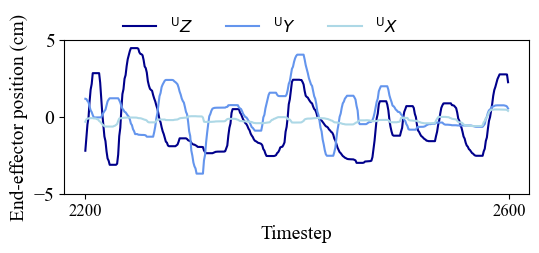

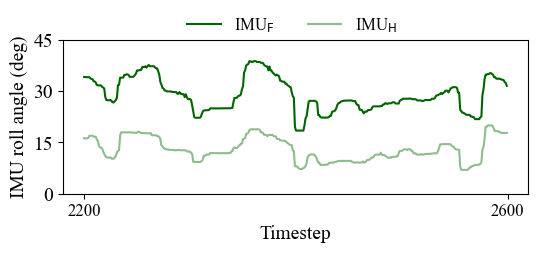

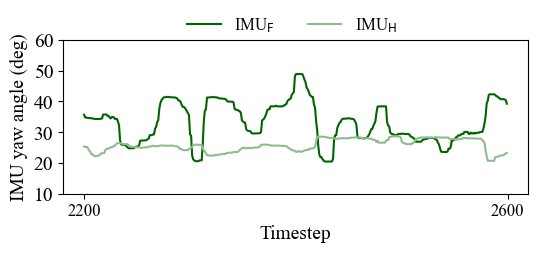

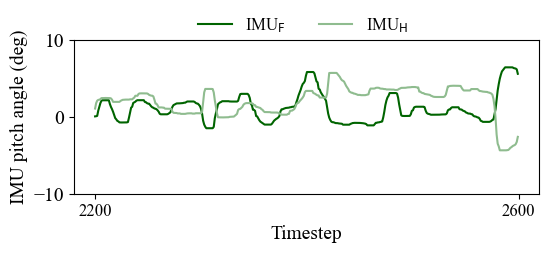

In [49]:
start_ind = 2200
end_ind = 2600
x = np.arange(len(df_data))[start_ind:end_ind]
y1 = df_data[" falcon_x"][start_ind:end_ind]
y2 = df_data[" falcon_y"][start_ind:end_ind]
y3 = df_data[" falcon_z"][start_ind:end_ind]
y4 = df_data["Yaw1"][start_ind:end_ind]
y5 = df_data["Pitch1"][start_ind:end_ind]
y6 = df_data["Roll1"][start_ind:end_ind]
y7 = df_data["Yaw2"][start_ind:end_ind]
y8 = df_data["Pitch2"][start_ind:end_ind]
y9 = df_data["Roll2"][start_ind:end_ind]
y0 = df_data["Pitch"][start_ind:end_ind]
# y2 = df_data["PosY2"][start_ind:end_ind]
# y3 = df_data["PosZ1"][start_ind:end_ind]
# y4 = df_data["PosZ2"][start_ind:end_ind]

# plot Falcon position
plt.figure(figsize=(6,2))
plt.plot(x, -y1*2.54, markersize=12,color='darkblue',markeredgecolor='black')
plt.plot(x, y2*2.54, markersize=12,color='cornflowerblue',markeredgecolor='black')
plt.plot(x, -y3*2.54, markersize=12,color='lightblue',markeredgecolor='black')
plt.ylabel(r'End-effector position (cm)', fontsize=14, fontname='Times New Roman')
plt.xlabel('Timestep', fontsize=14, fontname='Times New Roman')
plt.xticks([start_ind, end_ind], fontsize=12, fontname='Times New Roman')
plt.yticks([-5,0,5], fontsize=14, fontname='Times New Roman')
plt.legend([r'$^{\mathrm{U}}Z$','$^{\mathrm{U}}Y$','$^{\mathrm{U}}X$'],bbox_to_anchor=(0.75, 1.25), ncol=3, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.xlim([start_ind, end_ind])
# plt.ylim([-0.2, 0.2])
plt.savefig('Figure2c.pdf')
plt.show()

# plot IMU roll
plt.figure(figsize=(6,2))
plt.plot(x, y6, markersize=12,color='darkgreen',markeredgecolor='black')
plt.plot(x, y9, markersize=12,color='darkseagreen',markeredgecolor='black')
plt.ylabel(r'IMU roll angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xlabel('Timestep', fontsize=14, fontname='Times New Roman')
plt.xticks([start_ind, end_ind], fontsize=12, fontname='Times New Roman')
plt.yticks([0,15,30,45], fontsize=14, fontname='Times New Roman')
# plt.xlim([start_ind, end_ind])
# plt.ylim([-0.035, 0.035])
plt.legend([r'IMU$_\mathrm{F}$',r'IMU$_\mathrm{H}$'],bbox_to_anchor=(0.75, 1.25), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
plt.savefig('Figure2d.pdf')
plt.show()

# plot IMU pitch
plt.figure(figsize=(6,2))
plt.plot(x, y5, markersize=12,color='darkgreen',markeredgecolor='black')
plt.plot(x, y8, markersize=12,color='darkseagreen',markeredgecolor='black')
plt.ylabel(r'IMU yaw angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xlabel('Timestep', fontsize=14, fontname='Times New Roman')
plt.xticks([start_ind, end_ind], fontsize=12, fontname='Times New Roman')
plt.yticks([10,20,30,40,50,60], fontsize=14, fontname='Times New Roman')
# plt.xlim([start_ind, end_ind])
# plt.ylim([-0.035, 0.035])
plt.legend([r'IMU$_\mathrm{F}$',r'IMU$_\mathrm{H}$'],bbox_to_anchor=(0.75, 1.25), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure2e.pdf')
plt.show()

# plot IMU yaw
plt.figure(figsize=(6,2))
plt.plot(x, y4/3, markersize=12,color='darkgreen',markeredgecolor='black')
plt.plot(x, y7, markersize=12,color='darkseagreen',markeredgecolor='black')
plt.ylabel(r'IMU pitch angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xlabel('Timestep', fontsize=14, fontname='Times New Roman')
plt.xticks([start_ind, end_ind], fontsize=12, fontname='Times New Roman')
plt.yticks([-10,0,10], fontsize=14, fontname='Times New Roman')
# plt.xlim([start_ind, end_ind])
# plt.ylim([-0.035, 0.035])
plt.legend([r'IMU$_\mathrm{F}$',r'IMU$_\mathrm{H}$'],bbox_to_anchor=(0.75, 1.25), ncol=2, prop={'family':'Times New Roman', 'size':12}, frameon=False) 
# plt.savefig('Figure2f.pdf')
plt.show()
